# Analyse du commerce électronique brésilien

## Importations des librairies

In [51]:
import pandas as pd, numpy as np, os, warnings, seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)


if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)
warnings.filterwarnings(action="ignore")

os.chdir("C:/Users/etien/Documents/CCI/_HUB/cours/2024-2025/big_data/_git/Python_pandas/donnees")

## Importations des doonées 

In [52]:
ventes = pd.read_parquet('ecommerce/analyse_ventes.parquet', engine='pyarrow')
ventes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 68 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            99441 non-null  object        
 1   customer_id         99441 non-null  object        
 2   purchase_timestamp  99441 non-null  datetime64[us]
 3   approved_at         99281 non-null  datetime64[us]
 4   delivered_carrier   97658 non-null  datetime64[us]
 5   delivered_customer  96476 non-null  datetime64[us]
 6   estimated_delivery  99441 non-null  datetime64[us]
 7   status              99441 non-null  object        
 8   annee               99441 non-null  int32         
 9   mois                99441 non-null  int32         
 10  annee_mois          99441 non-null  int32         
 11  jour                99441 non-null  int32         
 12  annee_jour          99441 non-null  int32         
 13  jour_semaine        99441 non-null  int32     

### Concaténation de vente et produit

In [53]:
produits = pd.read_parquet('ecommerce/products.parquet', engine='pyarrow')


In [54]:
ventes = pd.read_parquet('ecommerce/analyse_ventes.parquet', engine='pyarrow')
achat = pd.read_parquet('ecommerce/analyse_achat.parquet', engine='pyarrow')
ventes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 68 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            99441 non-null  object        
 1   customer_id         99441 non-null  object        
 2   purchase_timestamp  99441 non-null  datetime64[us]
 3   approved_at         99281 non-null  datetime64[us]
 4   delivered_carrier   97658 non-null  datetime64[us]
 5   delivered_customer  96476 non-null  datetime64[us]
 6   estimated_delivery  99441 non-null  datetime64[us]
 7   status              99441 non-null  object        
 8   annee               99441 non-null  int32         
 9   mois                99441 non-null  int32         
 10  annee_mois          99441 non-null  int32         
 11  jour                99441 non-null  int32         
 12  annee_jour          99441 non-null  int32         
 13  jour_semaine        99441 non-null  int32     

In [55]:
ventes_achat = ventes.merge(achat[['order_id', 'product_id', 'category_name']], on='order_id', how='left')
ventes_achat_produits = ventes_achat.merge(produits[['product_id', 'weight_g', 'length_cm', 'height_cm', 'width_cm']], 
                                         on='product_id', how='left')


### Préparation des données

#### Nettoyage des valeurs extrem

In [56]:
achat_produit = ventes_achat_produits[(ventes_achat_produits['weight_g'] > 0) & (ventes_achat_produits['weight_g'] < ventes_achat_produits['weight_g'].quantile(0.99))]
achat_produit = ventes_achat_produits[(ventes_achat_produits['livree'] > 0) & (ventes_achat_produits['livree'] < ventes_achat_produits['livree'].quantile(0.99))]

In [57]:
ventes_payement = ventes.merge(achat[['order_id', 'category_name']], on='order_id', how='left')
ventes_payement['payment_method'] = ventes_payement[['int_boleto', 'int_credit_card', 'int_debit_card', 'int_voucher']].idxmax(axis=1)
#ventes_achat.info()

In [58]:
payment_labels = {
    'int_boleto': 'Boleto',
    'int_credit_card': 'Carte de crédit',
    'int_debit_card': 'Carte de débit',
    'int_voucher': 'Voucher'
}
ventes_payement['payment_method'] = ventes_payement['payment_method'].map(payment_labels)

### 1/ Les temps de livraison dépendent-ils de facteurs annexes ?

Quelles sont les dimensions qui ont un impact sur le temps de livraison ?

In [59]:
deliveryTime_by_period = ventes.groupby(['state', 'city', 'annee_trimestre'])['livree'].mean().reset_index()
deliveryTime_by_period

state             city  annee_trimestre     livree
0        AC        brasileia            20171   0.900000
1        AC  cruzeiro do sul            20174   2.297639
2        AC  cruzeiro do sul            20182  23.540556
3        AC   epitaciolandia            20174  10.963889
4        AC    manoel urbano            20173  11.257222
...     ...              ...              ...        ...
13524    TO   tocantinopolis            20174   3.322083
13525    TO   tocantinopolis            20181   4.264167
13526    TO   tocantinopolis            20182  10.511111
13527    TO          xambioa            20174   3.153056
13528    TO          xambioa            20183   8.562778

[13529 rows x 4 columns]

In [60]:
periode = ventes['annee_trimestre']

#### 1 - Distribution des temps de livraison par état

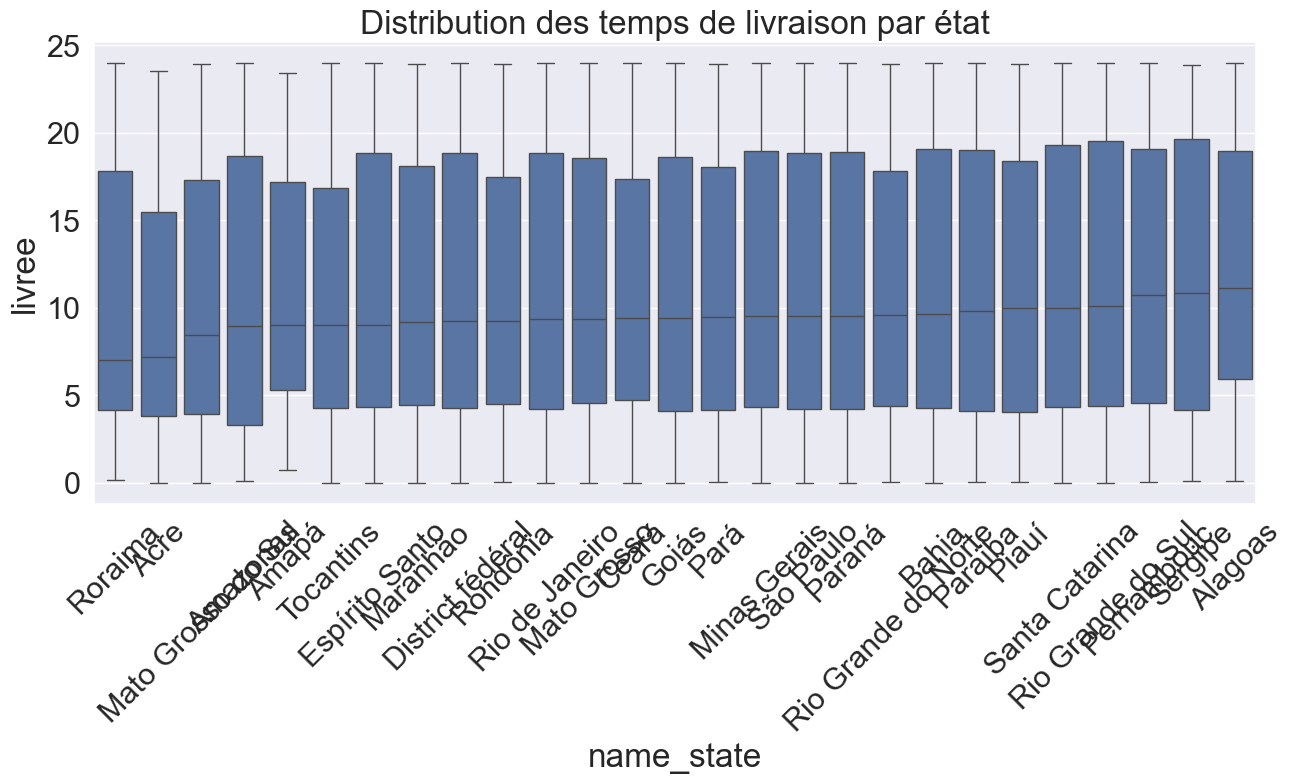

In [61]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=ventes, x='name_state', y='livree', order=ventes.groupby('name_state')['livree'].median().sort_values().index)
plt.xticks(rotation=45)
plt.title('Distribution des temps de livraison par état')
plt.show()

On remarque que les médianes des délais ne varie pas beaucoup d'un état à l'autre à l'exeption de certains état en dessous des autres. 

In [62]:
TO_deliveryTime_by_period = deliveryTime_by_period[deliveryTime_by_period['state'] == 'TO']
mask = ventes['annee_trimestre'].isin(periode) 
TO_deliveryTime_by_period = TO_deliveryTime_by_period[mask]
TO_deliveryTime_by_period.head(200)

state                  city  annee_trimestre     livree
13409    TO  alianca do tocantins            20181  23.877778
13410    TO  alianca do tocantins            20182  23.972222
13411    TO                 almas            20172  21.915556
13412    TO              alvorada            20172  19.882778
13413    TO              alvorada            20173  11.885833
...     ...                   ...              ...        ...
13524    TO        tocantinopolis            20174   3.322083
13525    TO        tocantinopolis            20181   4.264167
13526    TO        tocantinopolis            20182  10.511111
13527    TO               xambioa            20174   3.153056
13528    TO               xambioa            20183   8.562778

[120 rows x 4 columns]

#### 2 - Densité des temps de livraison pas période

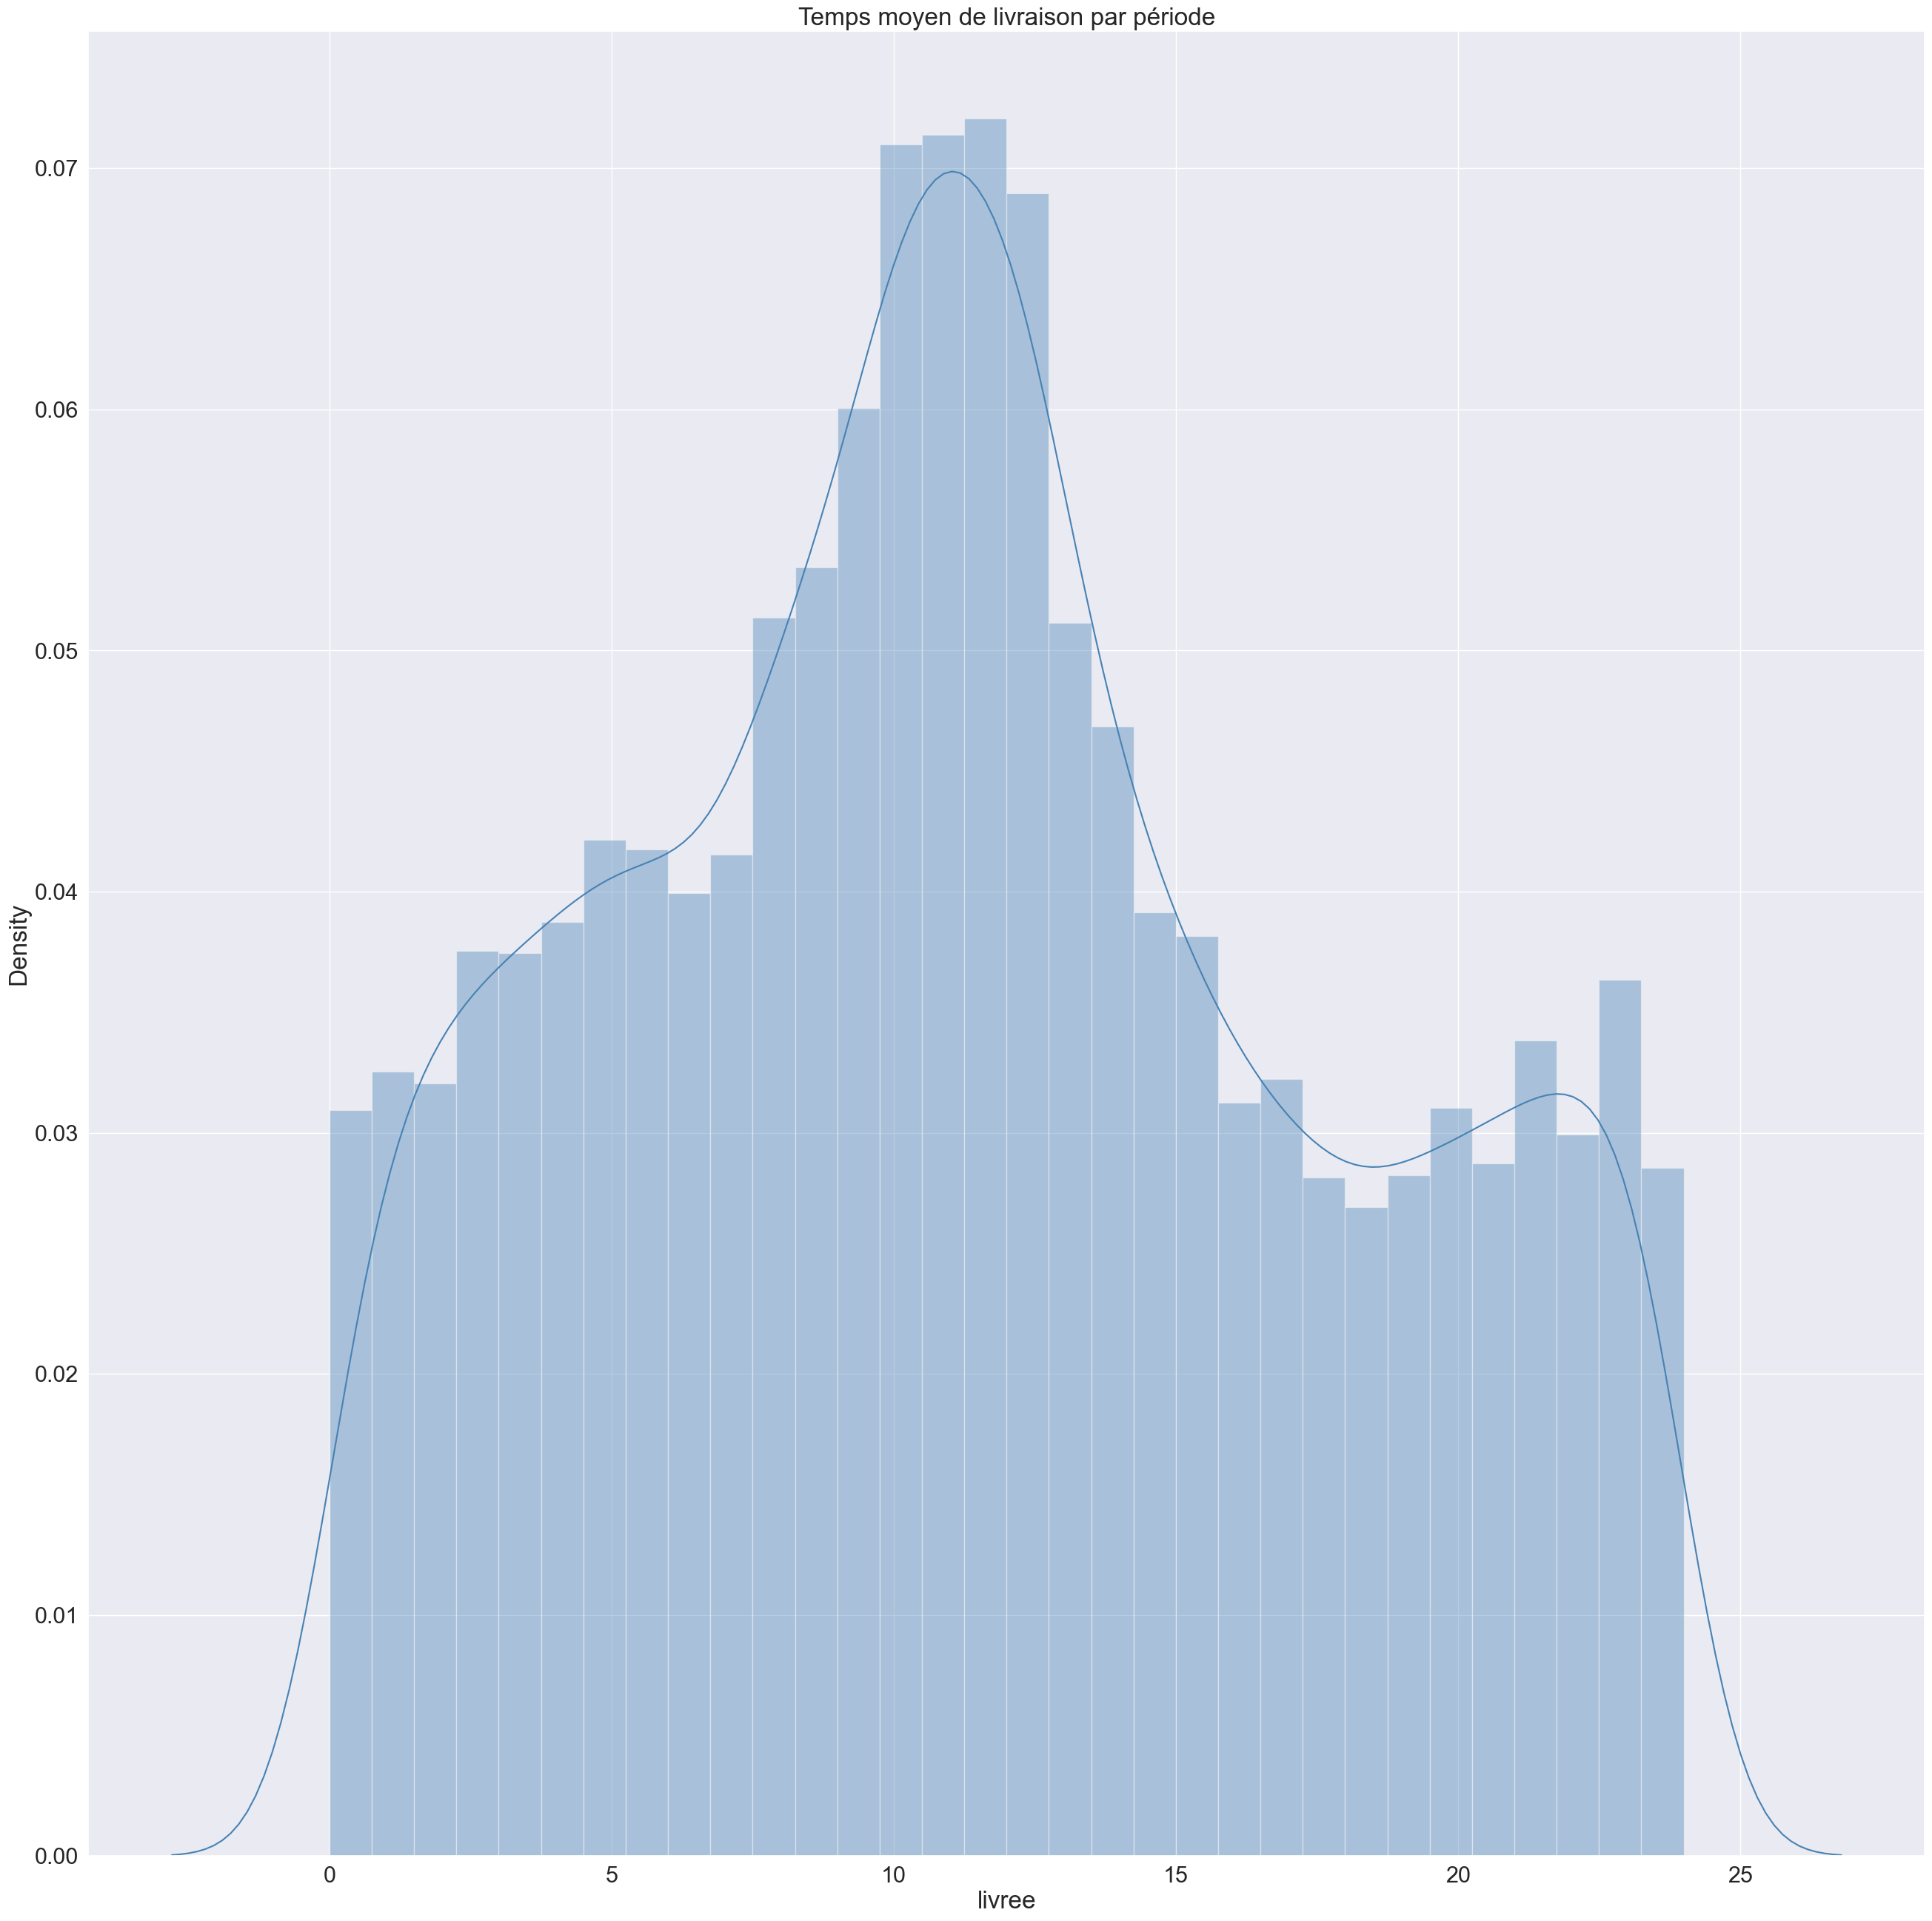

In [63]:
plt.figure(figsize=(32,32))
plt.title('Temps moyen de livraison par période', fontproperties=font2)
sns.distplot(deliveryTime_by_period['livree'], color="steelblue")
plt.show()

- La plus part des livraisons se font en 10 jours
- La distribution a une forme gaussienne avec une queue plus étalée vers la droite ce qui indique des cas où les livraison prennent plus de temps. En effet, il y a un deuxième pic dans les 20 jours qui pourrait correspondre aux livraison ayant un retard. 

#### 3 - représentaion de la distribution des temps de livraison par état

RR  :  9.886470189701896
AC  :  9.55711111111111


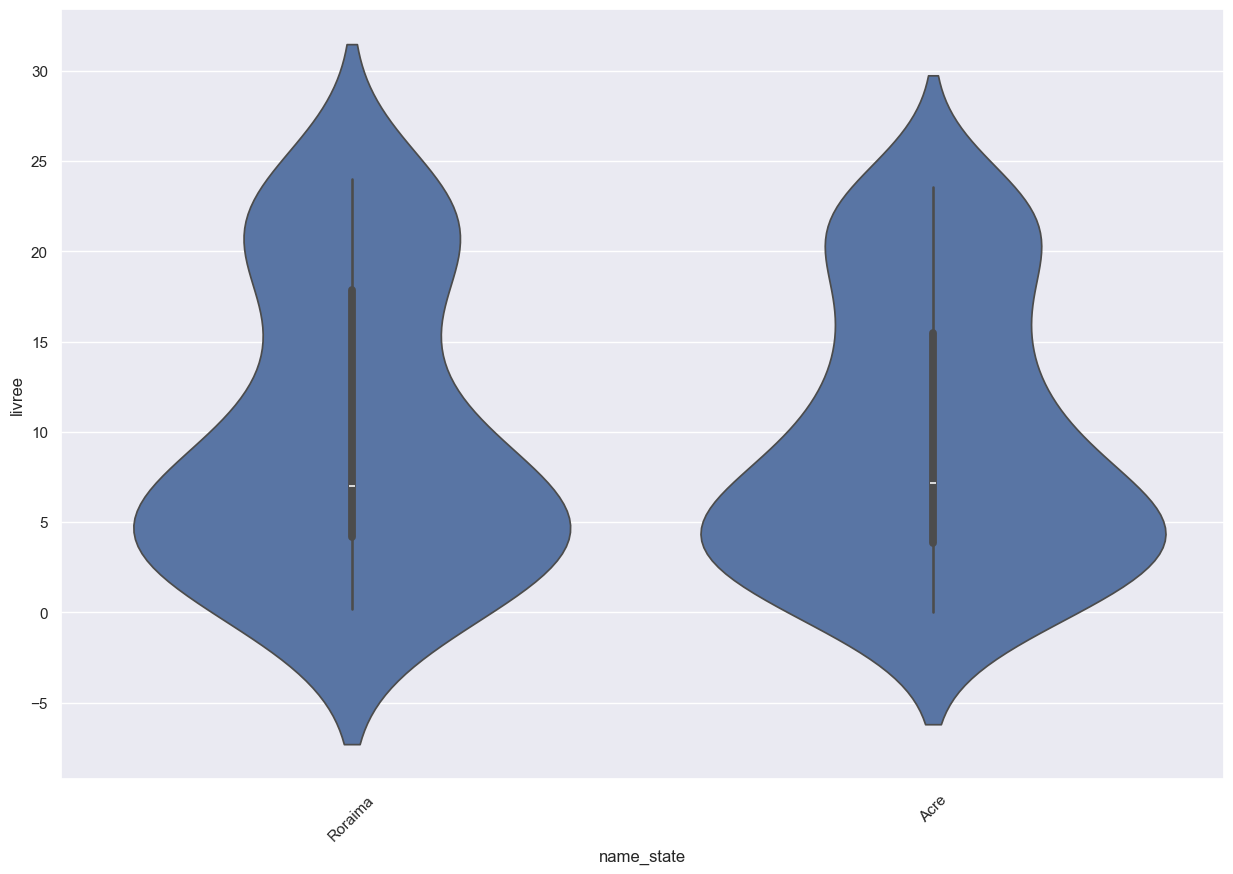

In [64]:
# https://mode.com/blog/violin-plot-examples


sns.set_theme(rc={'figure.figsize':(15, 10)})

country = ventes['state'].unique()

def getCountry_by_meanDelivery(country, nMean = 10):
    result = pd.DataFrame()
    for i in range(len(country)):
        countryName = country[i]
        currentCountryData = ventes[ventes['state'] == countryName] 
        if(currentCountryData["livree"].mean() < nMean):
            print(countryName, " : ", currentCountryData["livree"].mean())
            result = pd.concat([result, currentCountryData], ignore_index = True)
    return result

data = getCountry_by_meanDelivery(country, 10)

sns.violinplot(data = data, x = 'name_state', y = 'livree', width=0.8)
plt.xticks(rotation=45)
plt.show()

- Meme avec des pays qui des distributions assez éloigné (graph. 1) les différences sont minimes

#### 4 - Carte des temps de livraison moyen

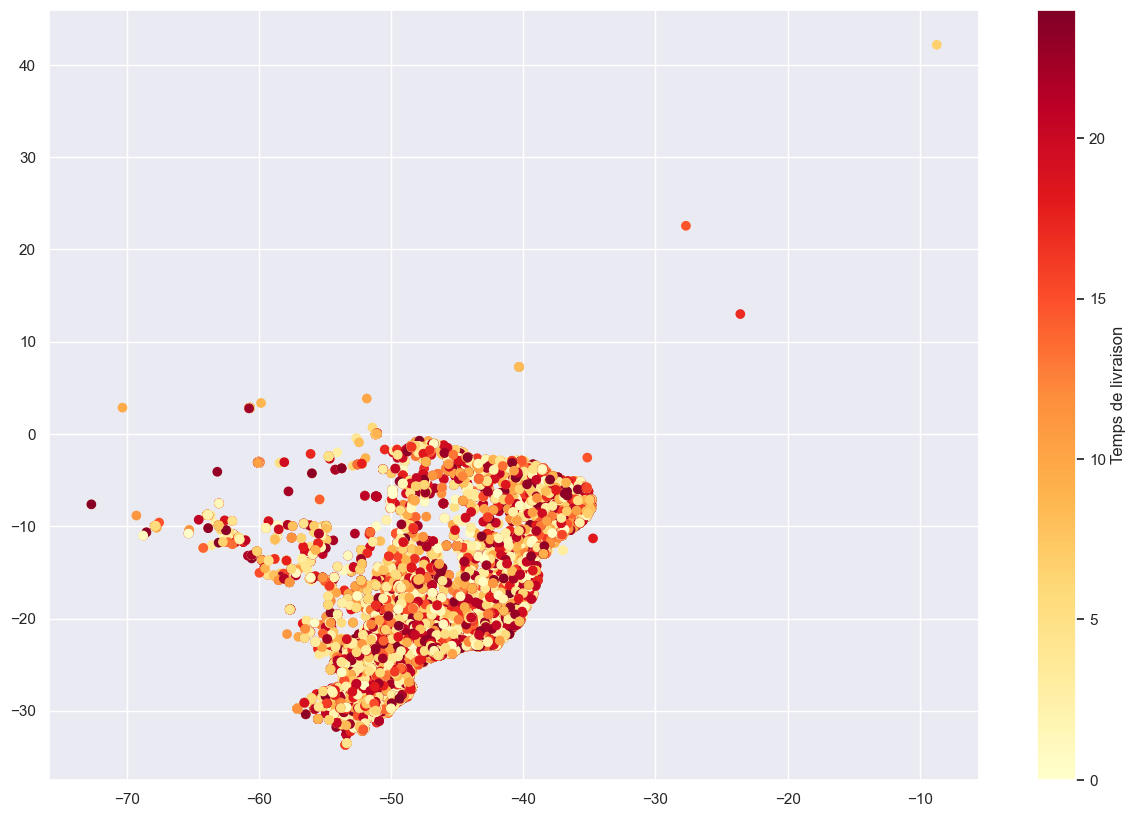

In [65]:
plt.scatter(ventes['lng'], ventes['lat'], c=ventes['livree'], cmap='YlOrRd')
plt.colorbar(label='Temps de livraison')
plt.show()

- IL y a beaucoup de point foncé dans le Nord-Ouest de l'Amazonie ce qui montre une faiblesse logistic dans ces zones. 
- Une grande concentration de point jaune dans les régions de Sao Paulo & Rio de Janeiro montre à l'inverse une meilleurs logistique, mais aussi probablement des distance plus courte. 
- Cependant cette analyse n'est pas absolue puisque le sud et les côte présente un nombre conséquent de point rouge. 

#### 5 - Temps de livraison moyen par trimestre et par ville 

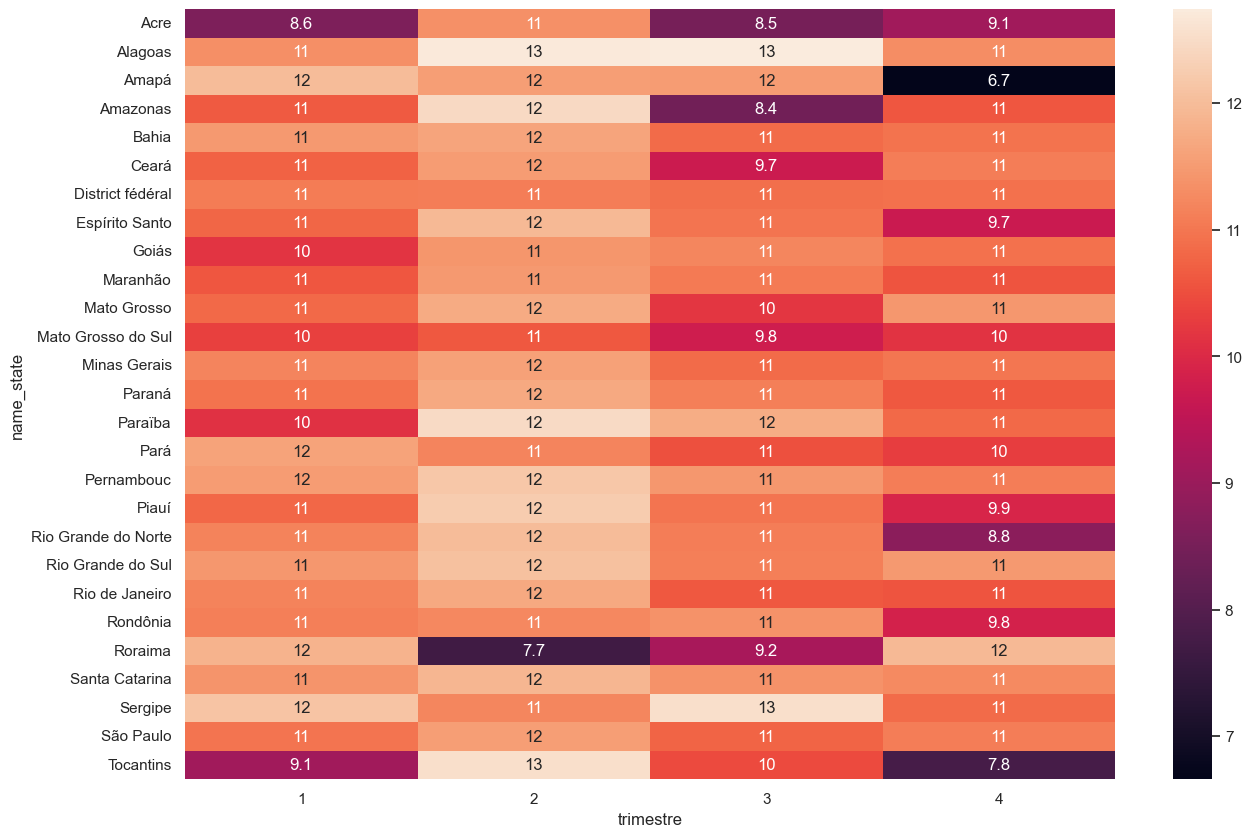

In [66]:
delivery_heatmap = ventes.pivot_table(
    values='livree',
    index='name_state',
    columns='trimestre',
    aggfunc='mean'
)
sns.heatmap(delivery_heatmap, annot=True)
plt.show()

- Certains États montrent des variations notables des délais selon les trimestres :
    - Roraima (RR) : 12 jours au T1, chute à 7,7 jours au T2, puis remonte progressivement.
    - Amazonas (AM) : 12 jours au T1, baisse à 8,4 jours au T3, puis stabilisation.
    - Amapá (AP) : Passe de 12 jours au T1 à seulement 6,7 jours au T4.
    - Mato Grosso do Sul (MS) : Variations de 10 jours à 9,8 jours, puis retour à 10 jours.

- Pourquoi ces variations ?

    - Ces États étant géographiquement **éloignés et moins industrialisés**, ils peuvent être **plus sensibles aux changements saisonniers** ou aux fluctuations logistiques.


- Périodes avec des délais légèrement plus élevés

    - Trimestre 2 et 3 (avril-septembre) semblent plus optimisés, avec plusieurs États enregistrant une baisse temporaire des délais.
    - Trimestre 1 et 4 (janvier-mars et octobre-décembre) montrent des délais plus longs, probablement à cause :
        - Du nouvel an et des soldes de début d’année (T1).
        - Du Black Friday et des fêtes de fin d’année (T4).

#### 6 - Comparaison des temps de livraison de tout les Etat

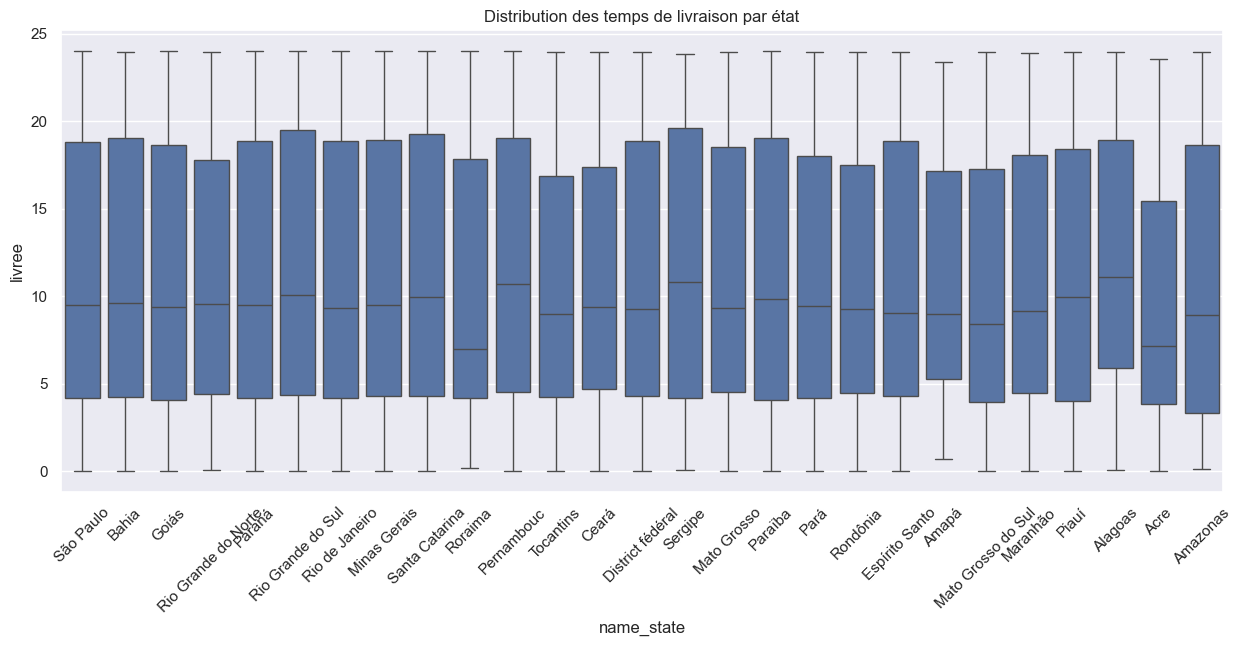

In [67]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=ventes, x='name_state', y='livree')
plt.xticks(rotation=45)
plt.title('Distribution des temps de livraison par état')
plt.show()

#### 7 - Evolution du temps de livraison par rapport au temps estimé en fonction du trimestre pour une région

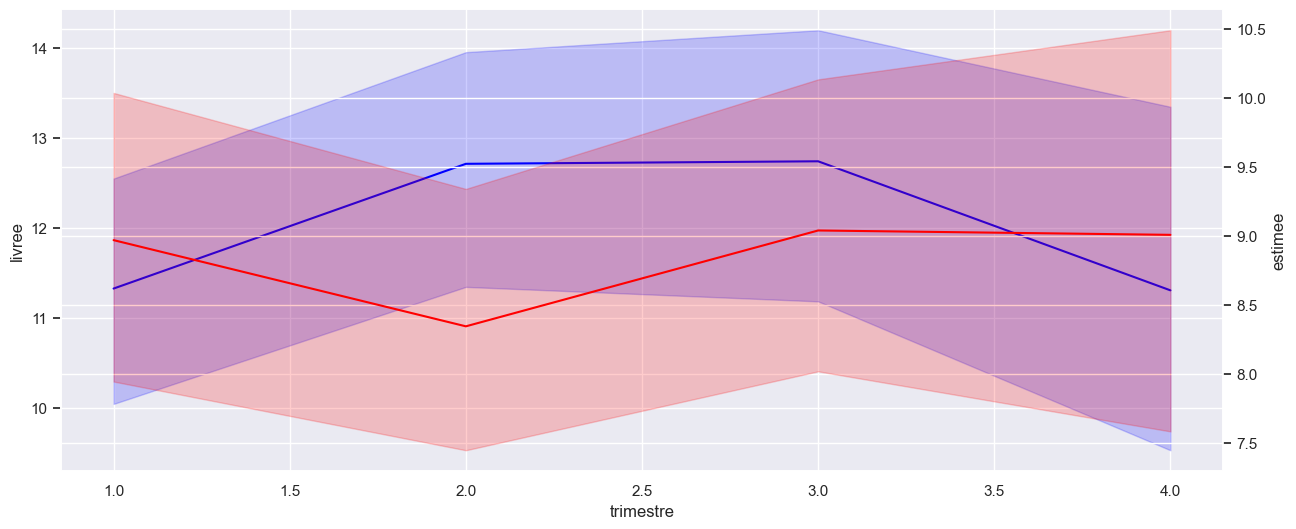

In [68]:
TO = ventes[ventes['state'] == 'AL']

fig, ax1 = plt.subplots(figsize=(15,6))
ax2 = ax1.twinx()
sns.lineplot(data=TO, x='trimestre', y='livree', ax=ax1, color='blue')
sns.lineplot(data=TO, x='trimestre', y='estimee', ax=ax2, color='red')
plt.show()

RR  :  9.886470189701896
AC  :  9.55711111111111


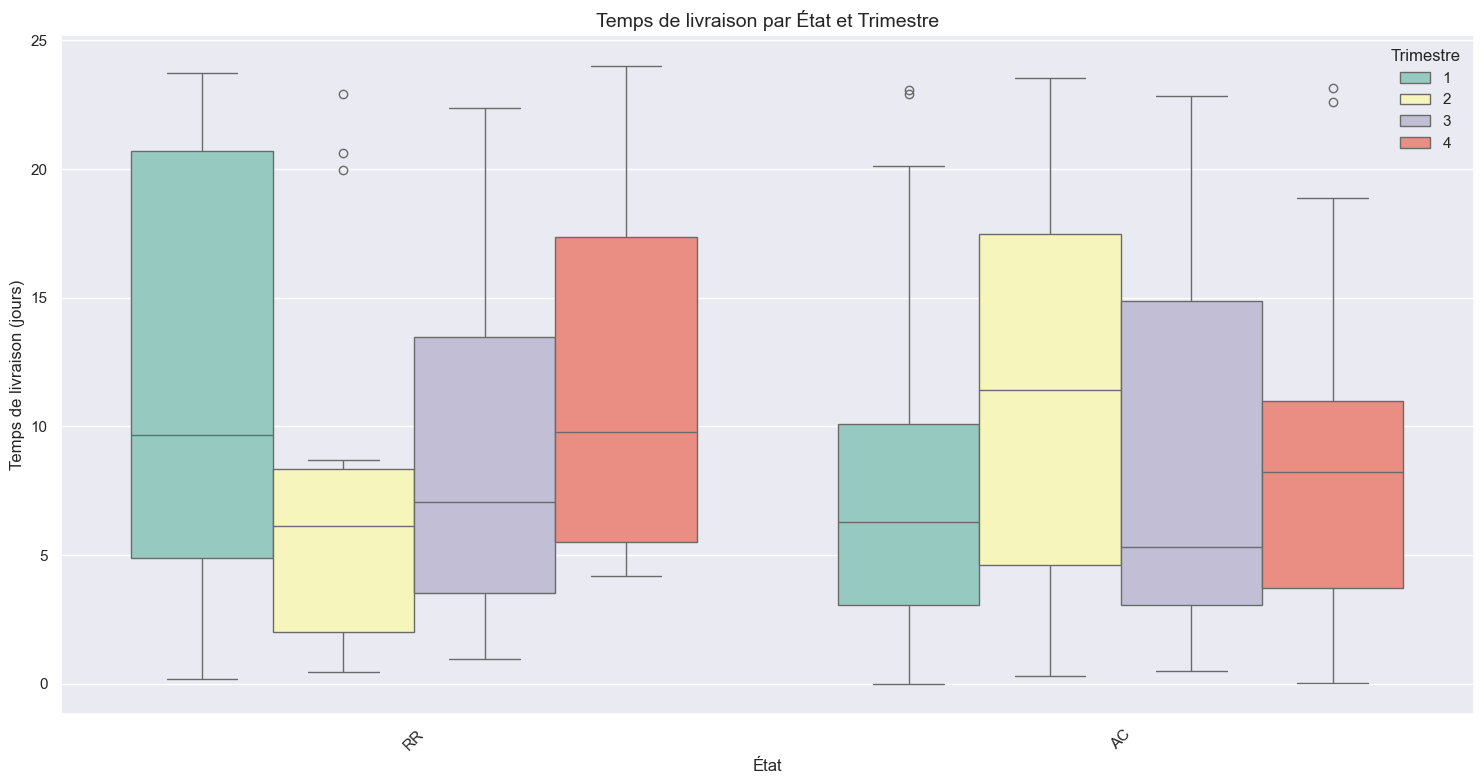

In [69]:

data = getCountry_by_meanDelivery(country, 10)

plt.figure(figsize=(15, 8))

sns.boxplot(data=data, 
            x='state',
            y='livree',
            hue='trimestre',
            palette='Set3')

plt.title('Temps de livraison par État et Trimestre', fontsize=14)
plt.xlabel('État', fontsize=12)
plt.ylabel('Temps de livraison (jours)', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='Trimestre')


plt.tight_layout()

plt.show()

#### 8 - Temps de livraison selon le poids du produit

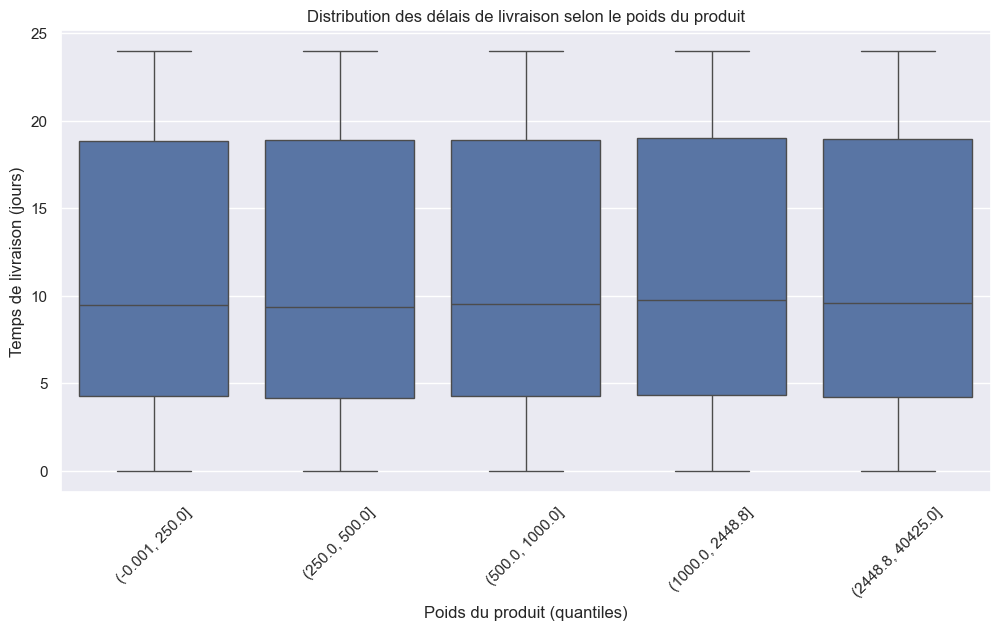

In [70]:
plt.figure(figsize=(12,6))
sns.boxplot(x=pd.qcut(ventes_achat_produits['weight_g'], q=5), y=ventes_achat_produits['livree'])
plt.xticks(rotation=45)
plt.xlabel("Poids du produit (quantiles)")
plt.ylabel("Temps de livraison (jours)")
plt.title("Distribution des délais de livraison selon le poids du produit")
plt.show()

Ce graphique nous montre qu'il n'y a aucune variation du temps de livraison en fonction du poids du produit

#### 9 - Relation Poids/Taille vs Temps de livraison

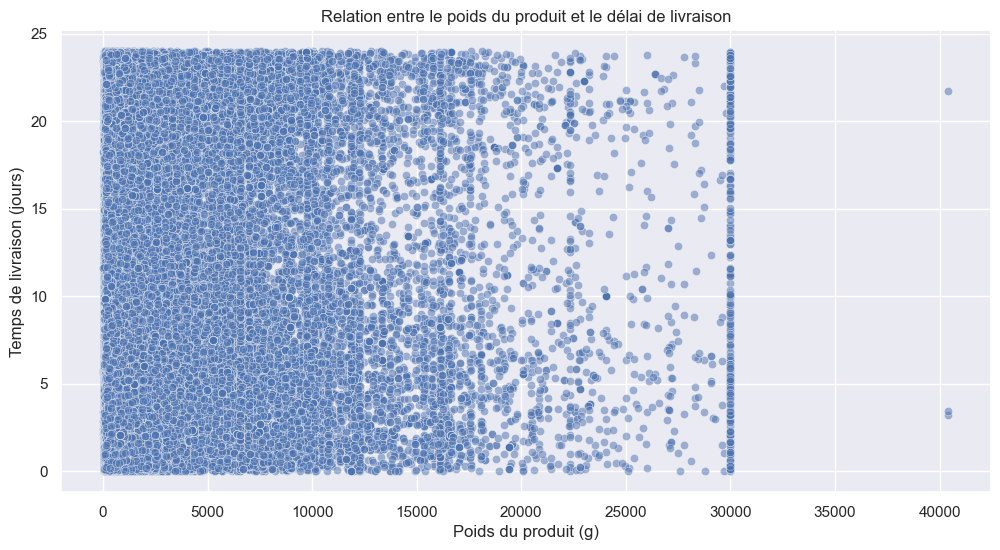

In [71]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=ventes_achat_produits, x=ventes_achat_produits['weight_g'], y=ventes_achat_produits['livree'], alpha=0.5)
plt.xlabel("Poids du produit (g)")
plt.ylabel("Temps de livraison (jours)")
plt.title("Relation entre le poids du produit et le délai de livraison")
plt.show()

#### 10 - Retards en fonction des dimensions du produit 

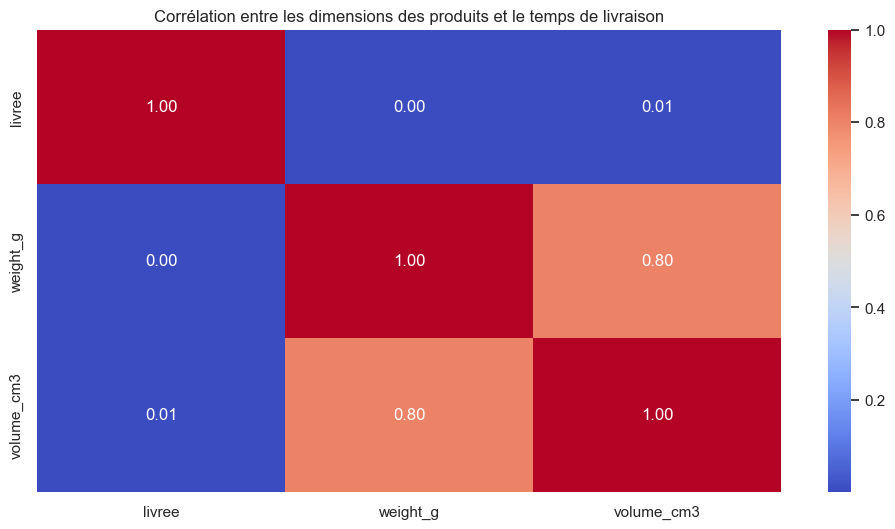

In [72]:
ventes_achat_produits['volume_cm3'] = ventes_achat_produits['length_cm'] * ventes_achat_produits['height_cm'] * ventes_achat_produits['width_cm']

plt.figure(figsize=(12,6))
corr_matrix = ventes_achat_produits[['livree', 'weight_g', 'volume_cm3']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélation entre les dimensions des produits et le temps de livraison")
plt.show()

Il n'y a aucun rapport en le poids ou le volume et le délais de livraison. 

#### 11 - Temps moyen de livraison par mode de paiement

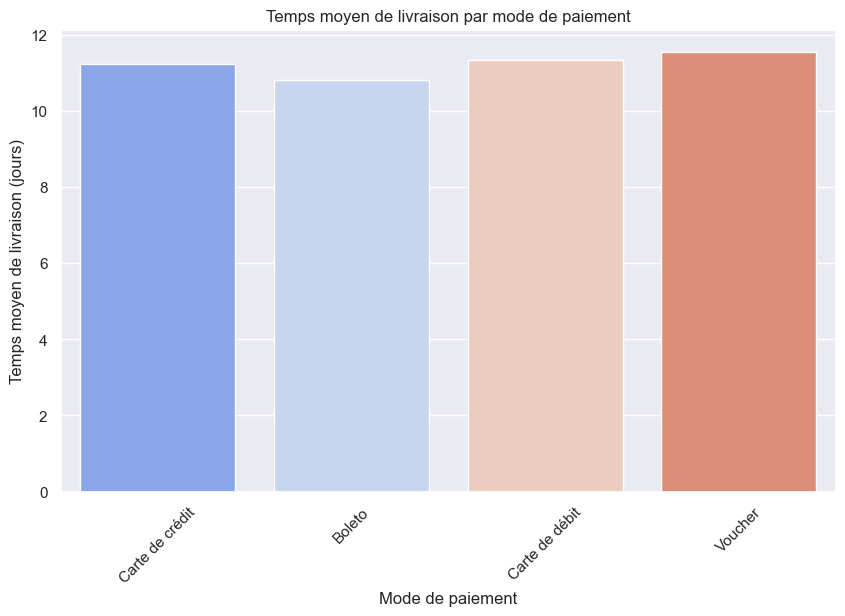

In [73]:
plt.figure(figsize=(10,6))
sns.barplot(data=ventes_payement, x='payment_method', y='livree', ci=None, palette="coolwarm")
plt.xlabel("Mode de paiement")
plt.ylabel("Temps moyen de livraison (jours)")
plt.title("Temps moyen de livraison par mode de paiement")
plt.xticks(rotation=45)
plt.show()

De même, le moyen de payement n'a pas d'impact sur le temps de livraison.

#### 12 - Comparaison des écarts de livraison selon le paiement

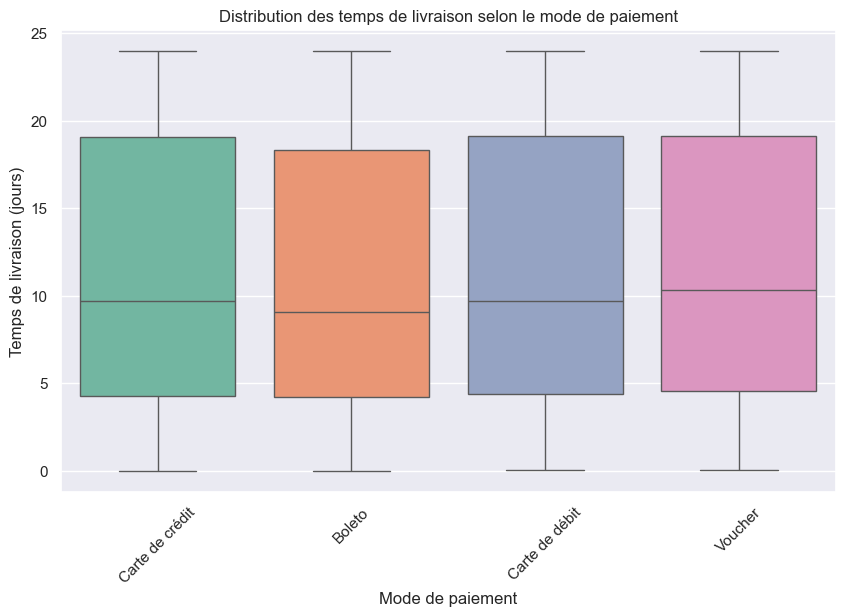

In [74]:
plt.figure(figsize=(10,6))
sns.boxplot(data=ventes_payement, x='payment_method', y='livree', palette="Set2")
plt.xlabel("Mode de paiement")
plt.ylabel("Temps de livraison (jours)")
plt.title("Distribution des temps de livraison selon le mode de paiement")
plt.xticks(rotation=45)
plt.show()

#### 13 - Répartition des paiements selon les délais

<Figure size 1000x600 with 0 Axes>

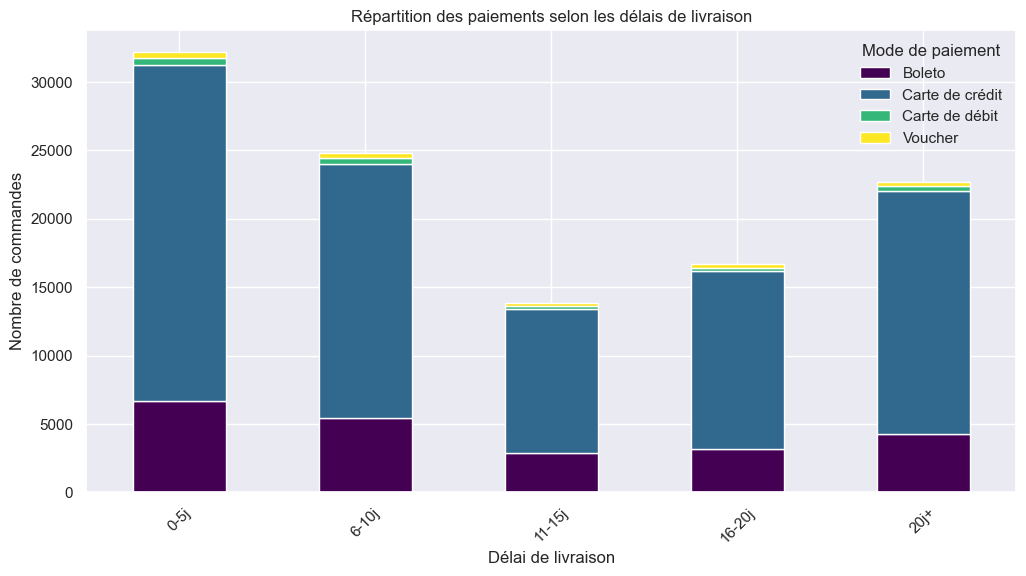

In [75]:

plt.figure(figsize=(10,6))
ventes_payement['livree_bins'] = pd.cut(ventes_payement['livree'], bins=[0, 5, 10, 15, 20, ventes_payement['livree'].max()], labels=["0-5j", "6-10j", "11-15j", "16-20j", "20j+"])
payment_delay_counts = ventes_payement.groupby(['livree_bins', 'payment_method']).size().unstack()
payment_delay_counts.plot(kind='bar', stacked=True, figsize=(12,6), colormap='viridis')
plt.xlabel("Délai de livraison")
plt.ylabel("Nombre de commandes")
plt.title("Répartition des paiements selon les délais de livraison")
plt.xticks(rotation=45)
plt.legend(title="Mode de paiement")
plt.show()

### 2/ Analyse de l'insatisfaction des clients

Nous essayons d'expliquer les facteurs clefs de l'insatisfaction des clients

#### 1 - Score globaux de satisfaction 

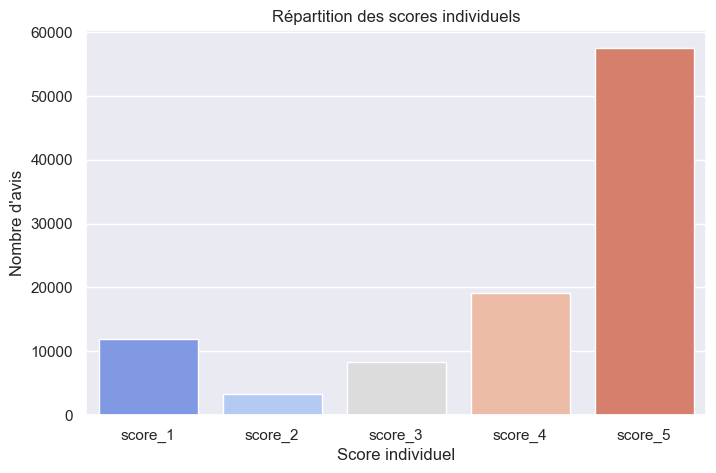

In [76]:
score_columns = ['score_1', 'score_2', 'score_3', 'score_4', 'score_5']
score_counts = ventes[score_columns].sum()

score_distribution = score_counts.reset_index()
score_distribution.columns = ['Score', 'Nombre']

plt.figure(figsize=(8,5))
sns.barplot(data=score_distribution, x='Score', y='Nombre', palette="coolwarm")
plt.xlabel("Score individuel")
plt.ylabel("Nombre d'avis")
plt.title("Répartition des scores individuels")
plt.show()

- On observe un proportion importante de score_1 par rapport aux score_2 & 3 
- L'évaluation des clients est assez binaire (satisfait / très insatisfait)

#### 2 - Proportion des retards

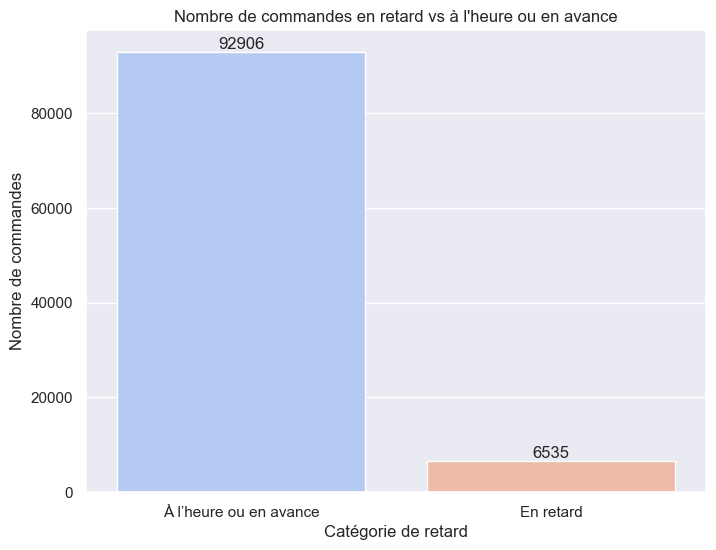

In [77]:
ventes['retard'] = (ventes['delivered_customer'] - ventes['estimated_delivery']).dt.days

ventes['retard_categorie'] = ventes['retard'].apply(lambda x: 'En retard' if x > 0 else 'À l’heure ou en avance')


retard_counts = ventes['retard_categorie'].value_counts()


plt.figure(figsize=(8, 6))
sns.barplot(x=retard_counts.index, y=retard_counts.values, palette="coolwarm")
plt.xlabel("Catégorie de retard")
plt.ylabel("Nombre de commandes")
plt.title("Nombre de commandes en retard vs à l'heure ou en avance")
for i, count in enumerate(retard_counts.values):
    plt.text(i, count + 100, f"{count}", ha='center', va='bottom', fontsize=12)
plt.show()

#### 3 - Score de satisfaction en fonction des délais de livraison 

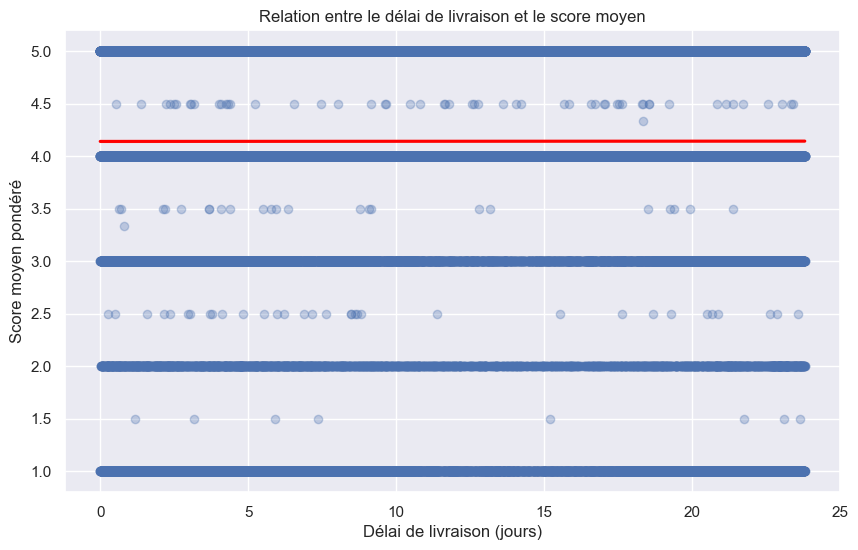

In [78]:

df_filtered = ventes[ventes['livree'] <= ventes['livree'].quantile(0.99)]


df_filtered['weighted_score'] = (
    df_filtered['score_1'] * 1 +
    df_filtered['score_2'] * 2 +
    df_filtered['score_3'] * 3 +
    df_filtered['score_4'] * 4 +
    df_filtered['score_5'] * 5
) / (df_filtered[['score_1', 'score_2', 'score_3', 'score_4', 'score_5']].sum(axis=1))


plt.figure(figsize=(10, 6))
sns.regplot(data=df_filtered, x='livree', y='weighted_score', scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.xlabel("Délai de livraison (jours)")
plt.ylabel("Score moyen pondéré")
plt.title("Relation entre le délai de livraison et le score moyen")
plt.show()

Ce graphique nous montre que les clients restent globalement satisfaits, mais que certains groupes spécifiques pénalisent fortement les délais long

#### 4 - Variation des scores par tranche de délais de livraison

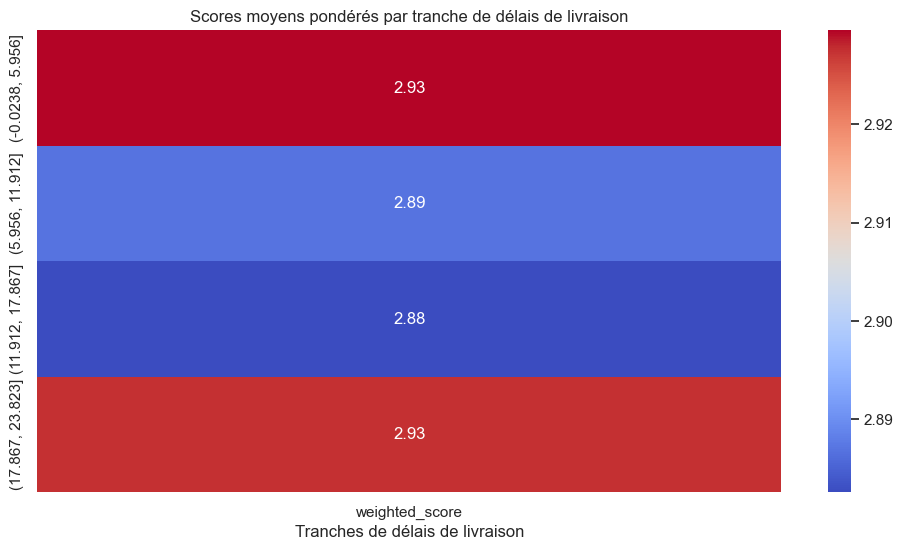

In [79]:

df_filtered['delivery_bins'] = pd.cut(df_filtered['livree'], bins=4)


df_pivot = df_filtered.groupby('delivery_bins').agg({
    'score_1': 'sum', 'score_2': 'sum', 'score_3': 'sum', 'score_4': 'sum'
})
df_pivot['weighted_score'] = (
    df_pivot['score_1'] * 1 +
    df_pivot['score_2'] * 2 +
    df_pivot['score_3'] * 3 +
    df_pivot['score_4'] * 4

) / df_pivot.sum(axis=1)


plt.figure(figsize=(12, 6))
sns.heatmap(df_pivot[['weighted_score']], annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.xlabel("Tranches de délais de livraison")
plt.ylabel("")
plt.title("Scores moyens pondérés par tranche de délais de livraison")
plt.show()

- Le score moyen oscille entre 2.88 et 2.93, ce qui signifie que les délais de livraison n’ont pas un impact dramatique sur la satisfaction globale.

- De manière surprenante, ceux ayant attendu plus de 18jours ont aussi un score moyen élevé 

- Cependant ce graphique représente les délais de livraison et non les retard ! 

La moyenne est moins lisse quand le produit arrive vite ou très lentement !

#### 5 - Focus sur les scores 1 & 5 

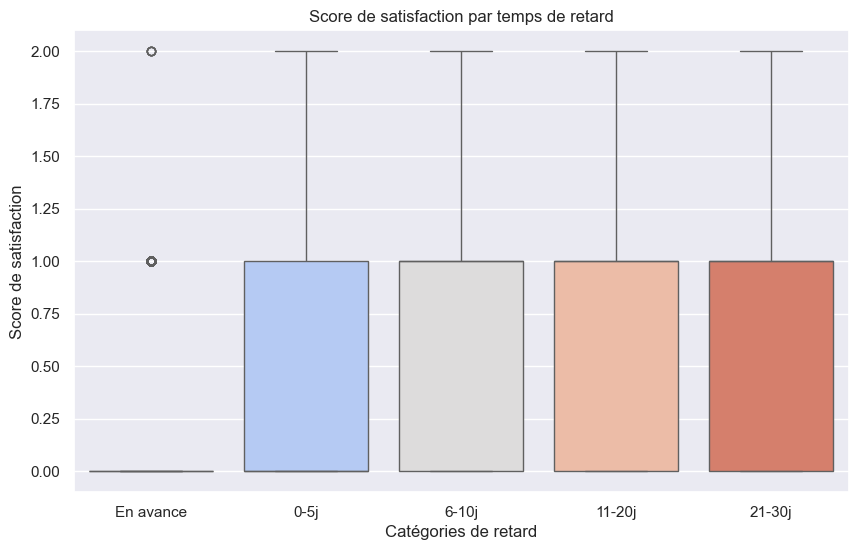

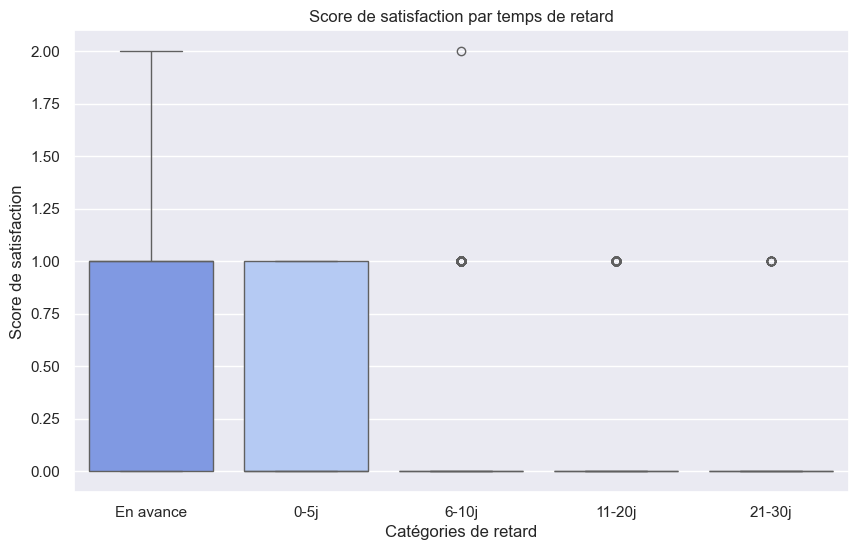

In [80]:


df_filtered = ventes[(ventes['retard'] >= -10) & (ventes['retard'] <= 30)]  # Retards entre -10 et 30 jours


plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x=pd.cut(df_filtered['retard'], bins=[-10, 0, 5, 10, 20, 30], labels=["En avance", "0-5j", "6-10j", "11-20j", "21-30j"]), y='score_1', palette="coolwarm")
plt.xlabel("Catégories de retard")
plt.ylabel("Score de satisfaction")
plt.title("Score de satisfaction par temps de retard")

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x=pd.cut(df_filtered['retard'], bins=[-10, 0, 5, 10, 20, 30], labels=["En avance", "0-5j", "6-10j", "11-20j", "21-30j"]), y='score_5', palette="coolwarm")
plt.xlabel("Catégories de retard")
plt.ylabel("Score de satisfaction")
plt.title("Score de satisfaction par temps de retard")

plt.show()

##### Graphique 1 (score_1)

- En prenant le temps de retard (et non le temps de livraison) on observe qu'une note base est toujours attribué quelque soit le temps de retard 

- A l'inverse il n'y a quasiment aucune note basse donné aux produit arrivé en avance

- Cependant, les note basse sont aussi données lorsque le retard est inexistant ou minim ce qui indique que le retard n'est pas la seul cause d'insatisfaction (score_1)


##### Graphique 2 (score_5)

- Contrairement aux notes de 1, aucune note de 5 n'est attribuée après un retard de 6 jours

- Un retard annule quasiment toute possibilité d'une note parfaite

#### 6 - Répartition des scores en fonction du retard  

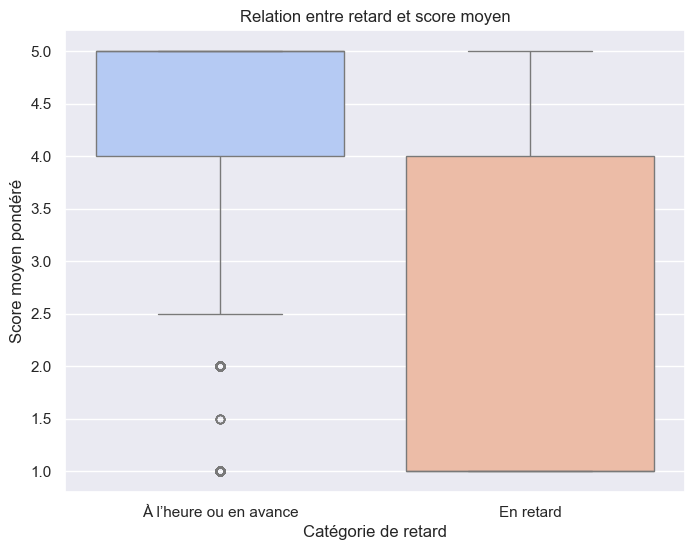

In [81]:


ventes['weighted_score'] = (
    ventes['score_1'] * 1 +
    ventes['score_2'] * 2 +
    ventes['score_3'] * 3 +
    ventes['score_4'] * 4 +
    ventes['score_5'] * 5
) / (ventes[['score_1', 'score_2', 'score_3', 'score_4', 'score_5']].sum(axis=1))


plt.figure(figsize=(8, 6))
sns.boxplot(data=ventes, x='retard_categorie', y='weighted_score', palette="coolwarm")
plt.xlabel("Catégorie de retard")
plt.ylabel("Score moyen pondéré")
plt.title("Relation entre retard et score moyen")
plt.show()

**Conclusion :** La plus part des clients dont les commandes sont arrivé en retard propose un score entre 1 et 3. En se référent au graphique deux on peut donc en déduire que 6300 note basse (1 à 3) peuvent être expliqué par un retard. 

#### 7 - Insatisfaction des clients par catégorie de produit

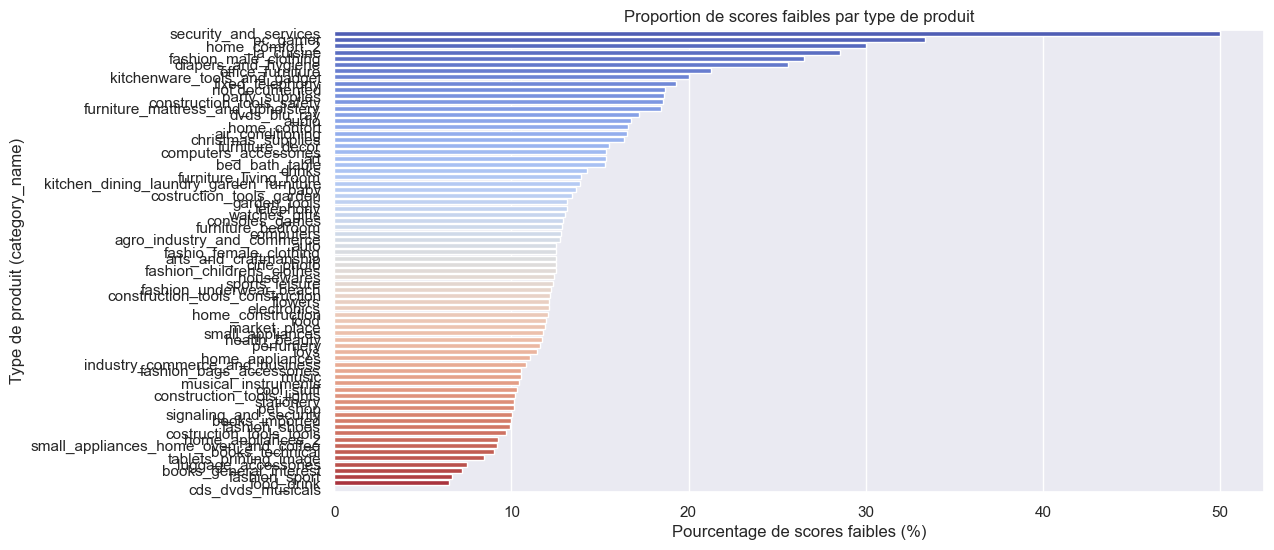

In [82]:

ventes_scores = ventes_achat_produits.groupby('category_name').agg(
    total_scores=('score_1', 'sum'),
    total_reviews=('score_1', 'count'),
    score_1_percentage=('score_1', lambda x: (x.sum() / x.count()) * 100)
).reset_index()


ventes_scores = ventes_scores.sort_values(by='score_1_percentage', ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(data=ventes_scores, x='score_1_percentage', y='category_name', palette="coolwarm")
plt.xlabel("Pourcentage de scores faibles (%)")
plt.ylabel("Type de produit (category_name)")
plt.title("Proportion de scores faibles par type de produit")
plt.show()

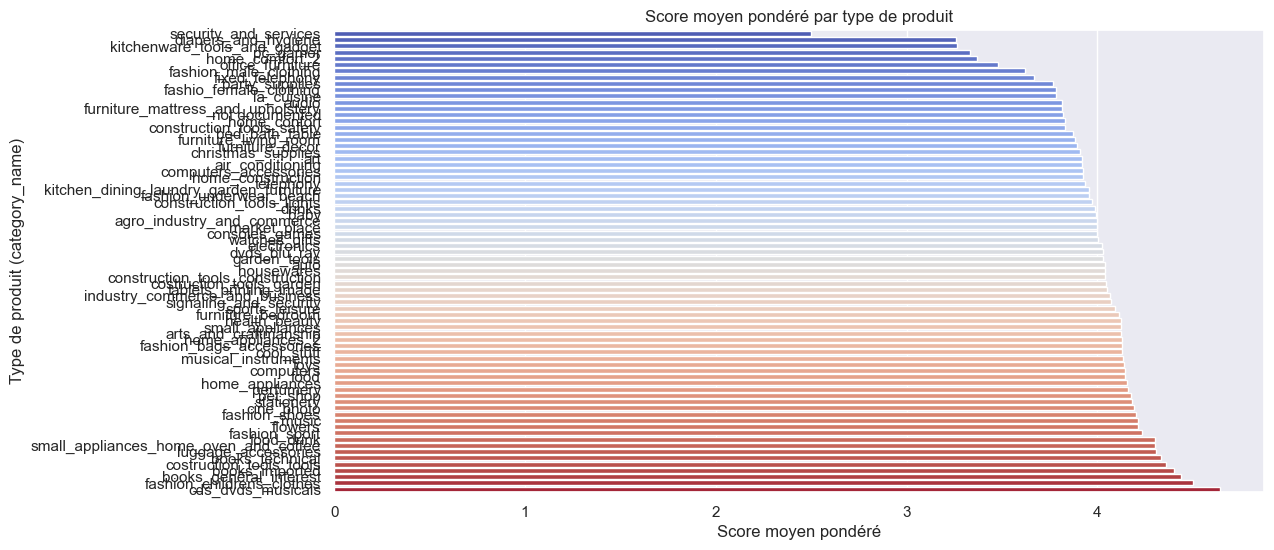

In [83]:
ventes_achat['weighted_score'] = (
    ventes_achat['score_1'] * 1 +
    ventes_achat['score_2'] * 2 +
    ventes_achat['score_3'] * 3 +
    ventes_achat['score_4'] * 4 +
    ventes_achat['score_5'] * 5
) / (ventes_achat[['score_1', 'score_2', 'score_3', 'score_4', 'score_5']].sum(axis=1))

df_avg_scores = ventes_achat.groupby('category_name').agg(
    avg_weighted_score=('weighted_score', 'mean')
).reset_index()

df_avg_scores = df_avg_scores.sort_values(by='avg_weighted_score', ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_avg_scores, x='avg_weighted_score', y='category_name', palette="coolwarm")
plt.xlabel("Score moyen pondéré")
plt.ylabel("Type de produit (category_name)")
plt.title("Score moyen pondéré par type de produit")
plt.show()

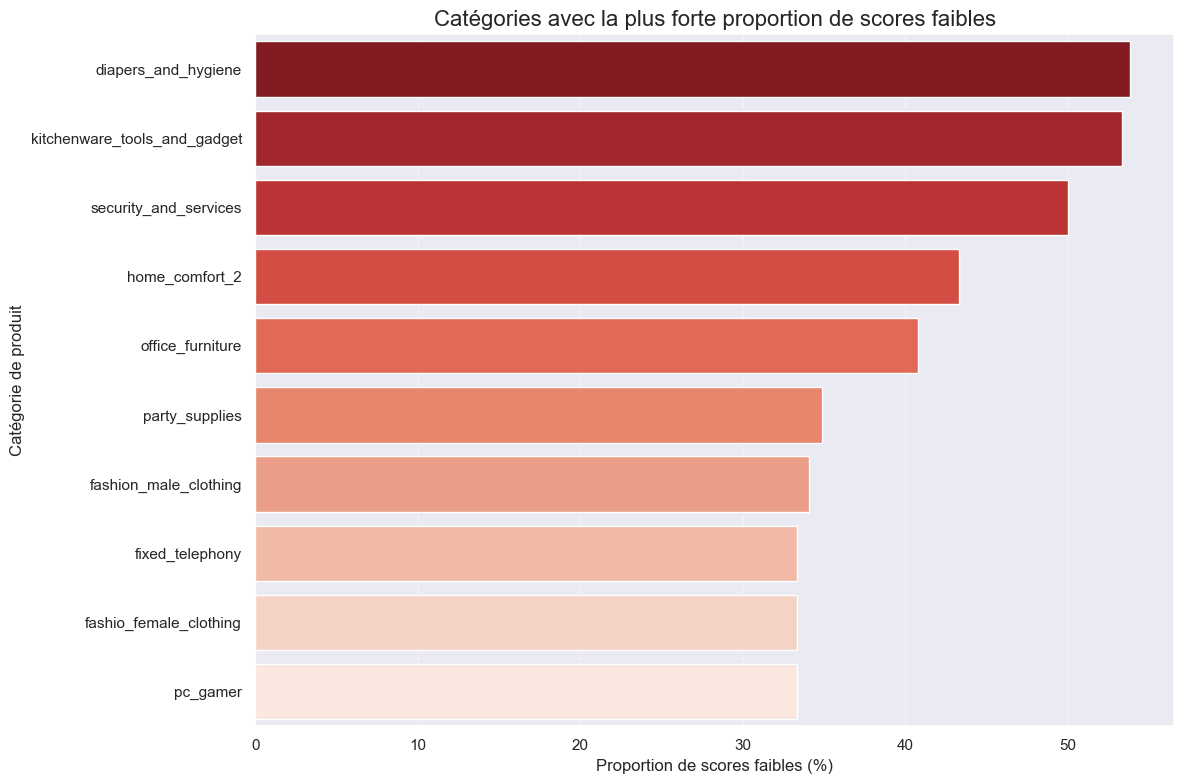

In [84]:
ventes_payement['is_score_low'] = ventes_payement[['score_1', 'score_2', 'score_3']].sum(axis=1) > 0


low_scores_by_category = ventes_payement.groupby('category_name').agg(
    total_low_scores=('is_score_low', 'sum'),
    total_reviews=('is_score_low', 'count')
).reset_index()

low_scores_by_category['low_score_percentage'] = (low_scores_by_category['total_low_scores'] / low_scores_by_category['total_reviews']) * 100


low_scores_by_category = low_scores_by_category.sort_values(by='low_score_percentage', ascending=False)


top_categories = low_scores_by_category.head(10)


plt.figure(figsize=(12, 8))
sns.barplot(data=top_categories, x='low_score_percentage', y='category_name', palette='Reds_r')
plt.xlabel("Proportion de scores faibles (%)")
plt.ylabel("Catégorie de produit")
plt.title("Catégories avec la plus forte proportion de scores faibles", fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Ces graphiques permettent de mettre en évidence les pires catégories de produit

#### 8 - Impacte des retards sur les catégories avec un haute insatisfaction 

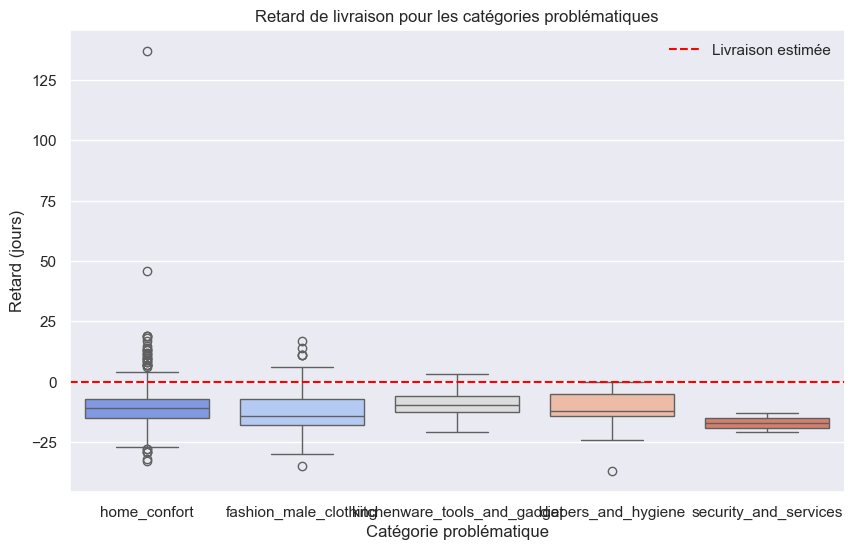

In [85]:
categories_problemes = ['security_and_services', 'home_confort', 'kitchenware_tools_and_gadget', 'diapers_and_hygiene', 'fashion_male_clothing']
df_problemes = ventes_achat_produits[ventes_achat_produits['category_name'].isin(categories_problemes)]

df_problemes['retard'] = (df_problemes['delivered_customer'] - df_problemes['estimated_delivery']).dt.days

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_problemes, x='category_name', y='retard', palette="coolwarm")
plt.axhline(0, color='red', linestyle='--', label="Livraison estimée")
plt.xlabel("Catégorie problématique")
plt.ylabel("Retard (jours)")
plt.title("Retard de livraison pour les catégories problématiques")
plt.legend()
plt.show()

Ce graphique montre l'insatisfaction des clients pour ces catégories n'est pas liée à un potentiel retard puisque les **ces catégories de produit ne présente pas des retard particulièrement élevé**.

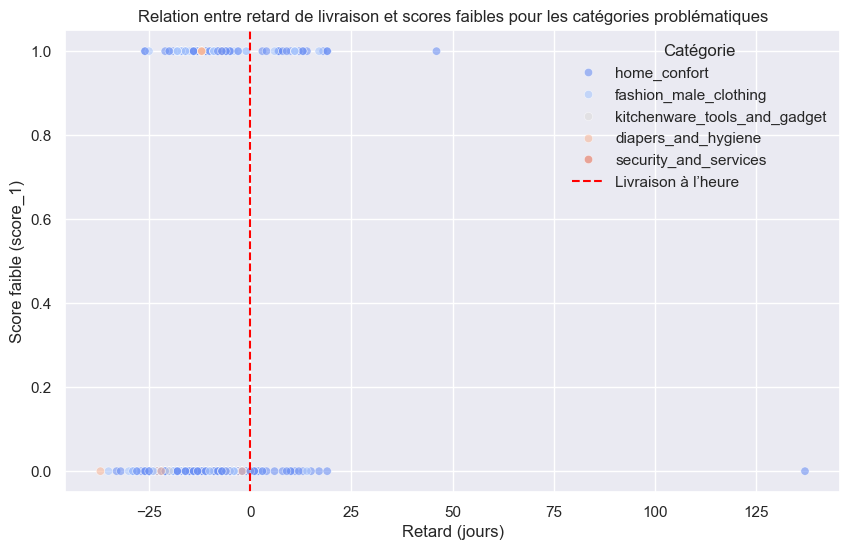

In [86]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_problemes, x='retard', y='score_1', hue='category_name', alpha=0.6, palette="coolwarm")
plt.axvline(0, color='red', linestyle='--', label="Livraison à l’heure")
plt.xlabel("Retard (jours)")
plt.ylabel("Score faible (score_1)")
plt.title("Relation entre retard de livraison et scores faibles pour les catégories problématiques")
plt.legend(title="Catégorie")
plt.show()

Ce graphique montre qu'une grand part des **score 1 est attribué alors même que la livraison est ponctuel**. Ainsi, pour ces catégories les retard ne sont effectivement pas le principale déclencheur de l'insatisfaction. 

#### 9 - Totale des insatisfactions pour les catégories problématique

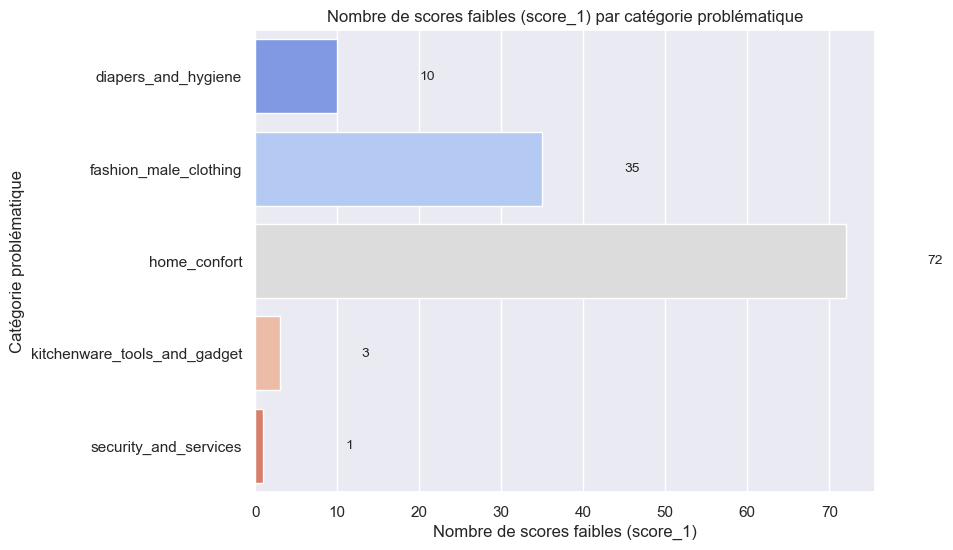

In [87]:
score_1_counts = df_problemes.groupby('category_name')['score_1'].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=score_1_counts, x='score_1', y='category_name', palette="coolwarm")
plt.xlabel("Nombre de scores faibles (score_1)")
plt.ylabel("Catégorie problématique")
plt.title("Nombre de scores faibles (score_1) par catégorie problématique")
for i, count in enumerate(score_1_counts['score_1']):
    plt.text(count + 10, i, f"{int(count)}", va='center', fontsize=10)
plt.show()

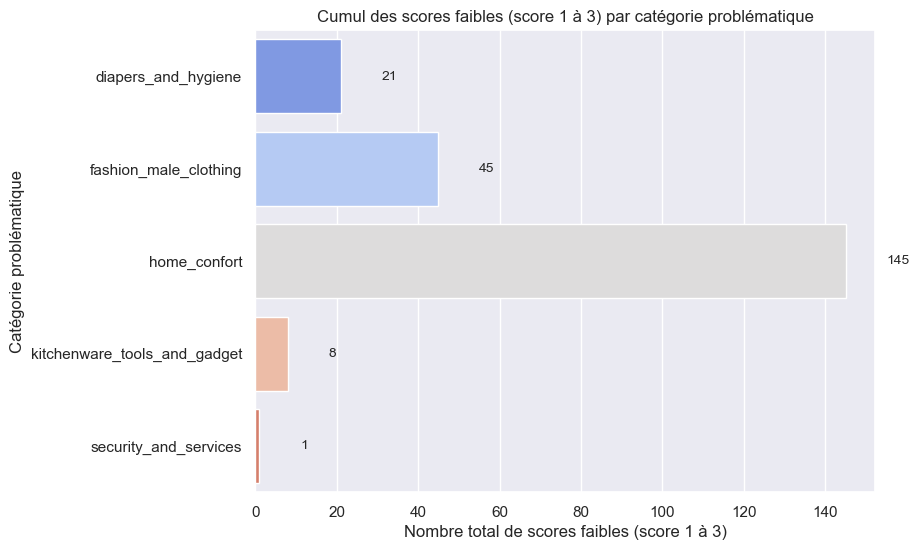

In [88]:
score_low_counts = df_problemes.groupby('category_name').agg(
    score_low_total=('score_1', 'sum'),
    score_medium_total=('score_2', 'sum'),
    score_medium_high_total=('score_3', 'sum')
).reset_index()

score_low_counts['total_score_1_to_3'] = (
    score_low_counts['score_low_total'] +
    score_low_counts['score_medium_total'] +
    score_low_counts['score_medium_high_total']
)


plt.figure(figsize=(8, 6))
sns.barplot(data=score_low_counts, x='total_score_1_to_3', y='category_name', palette="coolwarm")
plt.xlabel("Nombre total de scores faibles (score 1 à 3)")
plt.ylabel("Catégorie problématique")
plt.title("Cumul des scores faibles (score 1 à 3) par catégorie problématique")
for i, count in enumerate(score_low_counts['total_score_1_to_3']):
    plt.text(count + 10, i, f"{int(count)}", va='center', fontsize=10)
plt.show()

**Conclusion :** Ces catégories de produit problématique nous permettent d'expliquer 130 score faible supplémentaire. 

In [ ]:
valeurs_uniques = ventes_payement['payment_method'].unique()
print(f"Valeurs distinctes dans ventes['score_1'] : {valeurs_uniques}")

Valeurs distinctes dans ventes['score_1'] : ['Carte de crédit' 'Boleto' 'Carte de débit' 'Voucher' nan]


### 3/ Analyse des produits coûteux et des attentes

Identifier si les produits coûteux répondent aux attentes des clients en analysant les scores faibles.

#### 1 - Prix moyen de chaque catégorie d'article

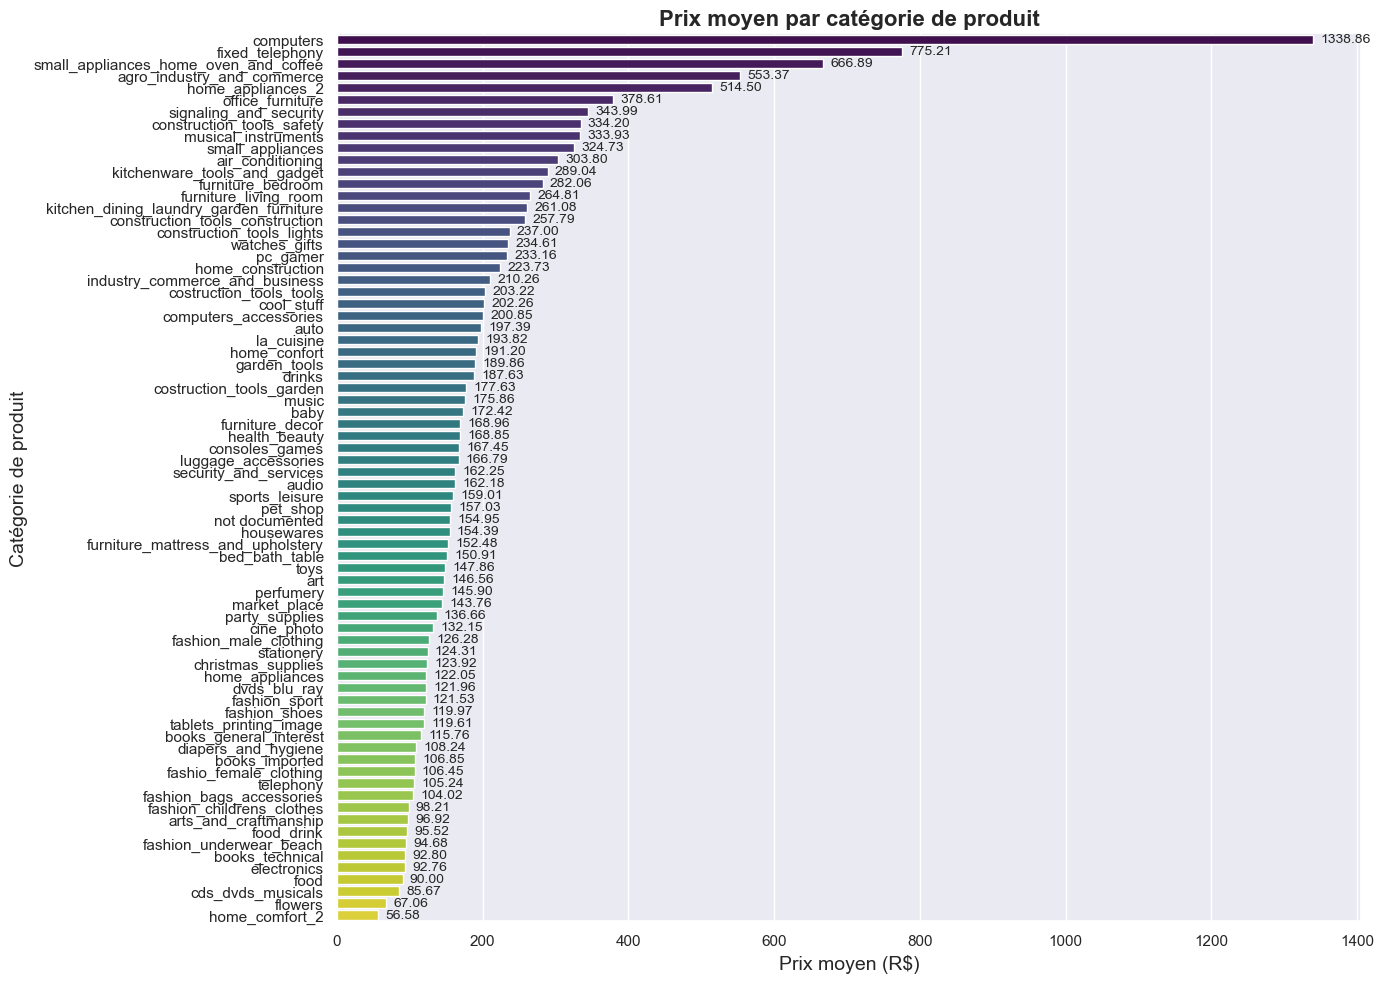

In [90]:

ventes_payement['price'] = np.select(
    [
        ventes_payement['payment_method'] == 'Boleto',
        ventes_payement['payment_method'] == 'Carte de crédit',
        ventes_payement['payment_method'] == 'Carte de débit',
        ventes_payement['payment_method'] == 'Voucher',
        ventes_payement['payment_method'].isnull()
    ],
    [
        ventes_payement['value_boleto'],
        ventes_payement['value_credit_card'],
        ventes_payement['value_debit_card'],
        ventes_payement['value_voucher'],
        ventes_payement['value_not_defined']
    ],
    default=0  
)


prix_moyen_par_categorie = ventes_payement.groupby('category_name')['price'].mean().reset_index()


prix_moyen_par_categorie = prix_moyen_par_categorie.sort_values(by='price', ascending=False)


plt.figure(figsize=(14, 10)) 
sns.barplot(data=prix_moyen_par_categorie, x='price', y='category_name', palette="viridis")
plt.xlabel("Prix moyen (R$)", fontsize=14)
plt.ylabel("Catégorie de produit", fontsize=14)
plt.title("Prix moyen par catégorie de produit", fontsize=16, weight='bold')


for i, price in enumerate(prix_moyen_par_categorie['price']):
    plt.text(price + 10, i, f"{price:.2f}", va='center', fontsize=10)


plt.tight_layout()
plt.show()

In [91]:
price_threshold = ventes_payement['price'].quantile(0.75)
df_couteux = ventes_payement[ventes_payement['price'] >= price_threshold].copy()


df_couteux['total_score'] = df_couteux[['score_1', 'score_2', 'score_3', 'score_4', 'score_5']].sum(axis=1)
df_couteux = df_couteux[df_couteux['total_score'] > 0]  

df_couteux['weighted_score'] = (
    (df_couteux['score_1'] * 1 +
     df_couteux['score_2'] * 2 +
     df_couteux['score_3'] * 3 +
     df_couteux['score_4'] * 4 +
     df_couteux['score_5'] * 5)
    / df_couteux['total_score']
)


top_categories = (
    df_couteux.groupby('category_name')['price'].mean()
    .sort_values(ascending=False)
    .head(10)
)


print("Top 10 des catégories les plus coûteuses :")
print(top_categories)

Top 10 des catégories les plus coûteuses :
category_name
fixed_telephony                          2075.345699
computers                                1357.971775
dvds_blu_ray                             1005.155000
small_appliances_home_oven_and_coffee     940.326731
kitchenware_tools_and_gadget              932.772500
signaling_and_security                    890.902581
agro_industry_and_commerce                855.416615
books_imported                            804.960000
drinks                                    782.418833
art                                       713.802500
Name: price, dtype: float64


#### 2 - Proportion des scores faible par prix et catégorie de produit

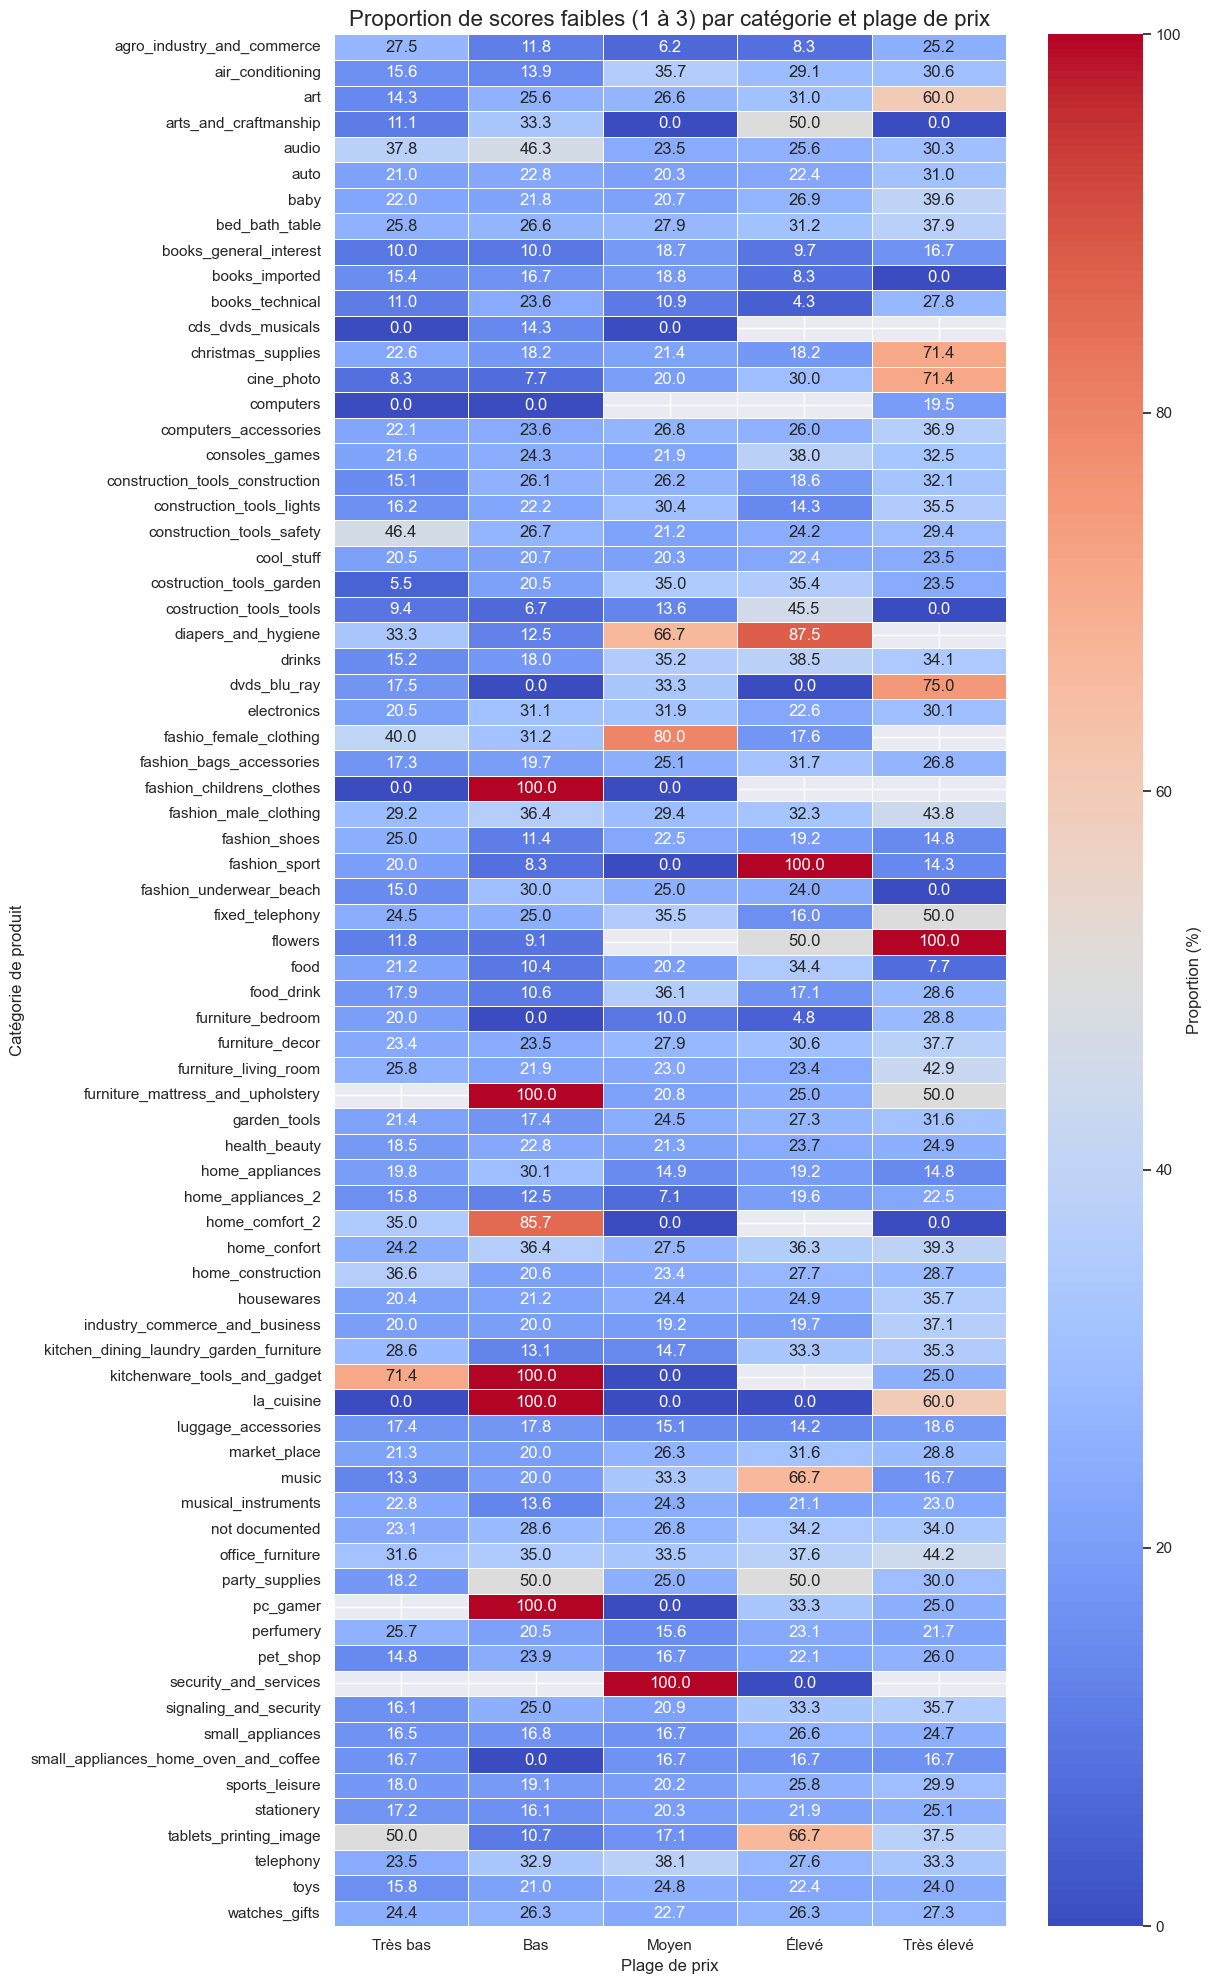

In [92]:
ventes_payement['is_score_low'] = ventes_payement[['score_1', 'score_2', 'score_3']].sum(axis=1) > 0


ventes_payement['price_range'] = pd.qcut(ventes_payement['price'], q=5, labels=["Très bas", "Bas", "Moyen", "Élevé", "Très élevé"])
heatmap_data = ventes_payement.groupby(['category_name', 'price_range']).agg(
    total_scores=('is_score_low', 'sum'),
    total_reviews=('is_score_low', 'count')
).reset_index()


heatmap_data['low_score_percentage'] = (heatmap_data['total_scores'] / heatmap_data['total_reviews']) * 100


heatmap_pivot = heatmap_data.pivot(index='category_name', columns='price_range', values='low_score_percentage')


plt.figure(figsize=(12, 20))
sns.heatmap(heatmap_pivot, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Proportion (%)'})
plt.title("Proportion de scores faibles (1 à 3) par catégorie et plage de prix", fontsize=16)
plt.xlabel("Plage de prix")
plt.ylabel("Catégorie de produit")
plt.tight_layout()
plt.show()

Certaines catégories très chères affichent des scores faibles élevés, comme :
- "Kitchenware_tools_and_gadget" (71.4% de scores faibles pour les prix bas et 100% - pour les prix moyens).
- "PC_gamer" (100% pour la catégorie la plus chère).
- "Security_and_services" (100% pour la tranche de prix la plus élevée).
- "La_cuisine" (100% pour la plage de prix moyen).

Explication possible : Ces produits coûtent cher, donc les attentes des clients sont très élevées.
Si le produit ne répond pas parfaitement aux attentes, même un petit défaut peut générer une forte insatisfaction.

#### 3 - Relation entre score faible et prix du produit

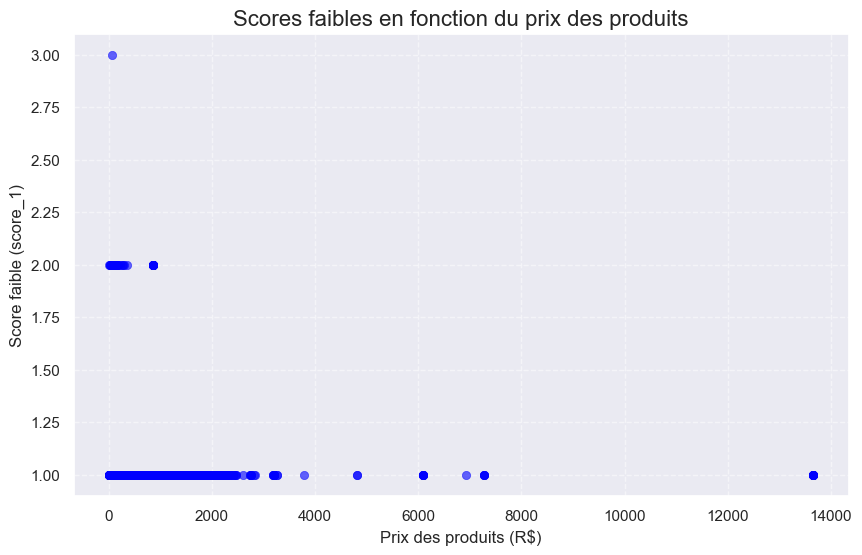

In [93]:
df_scores_faibles = ventes_payement[ventes_payement['score_1'] > 0]


df_scores_faibles['price'] = df_scores_faibles[
    ['value_boleto', 'value_credit_card', 'value_debit_card', 'value_voucher', 'value_not_defined']
].max(axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_scores_faibles, x='price', y='score_1', alpha=0.6, color='blue', edgecolor=None)
plt.xlabel("Prix des produits (R$)")
plt.ylabel("Score faible (score_1)")
plt.title("Scores faibles en fonction du prix des produits", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Ce graphique nous indique qu'il faut ajouter une dimension pour continuer notre analyse, bien qu'une forte proportion des notes faible soit attribué à des produit de bas prix, un prix faible est une mauvaise note ne semble pas être corrélés.

#### 4 - Distribution des scores moyens pondérés pour les produits coûteux

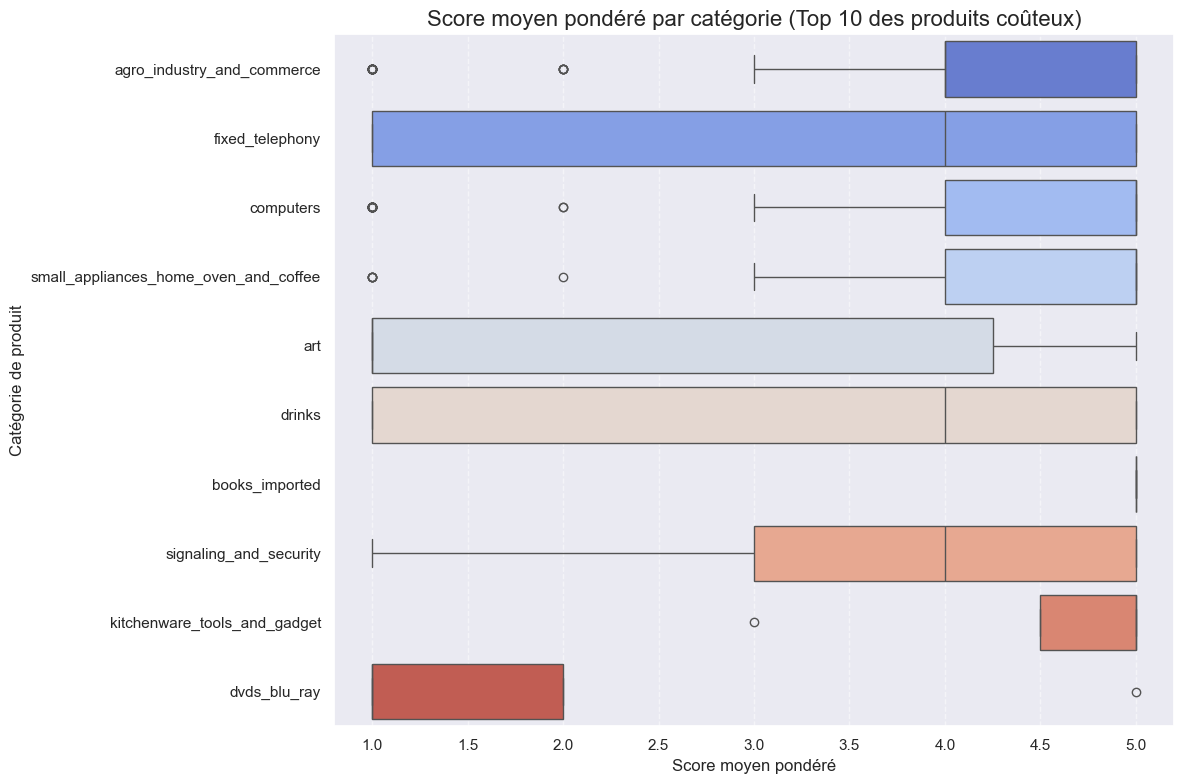

In [94]:
price_threshold = ventes_payement['price'].quantile(0.75)
df_couteux = ventes_payement[ventes_payement['price'] >= price_threshold]


df_couteux['weighted_score'] = (
    df_couteux['score_1'] * 1 +
    df_couteux['score_2'] * 2 +
    df_couteux['score_3'] * 3 +
    df_couteux['score_4'] * 4 +
    df_couteux['score_5'] * 5
) / (df_couteux[['score_1', 'score_2', 'score_3', 'score_4', 'score_5']].sum(axis=1))

top_categories = (
    df_couteux.groupby('category_name')['price'].mean()
    .sort_values(ascending=False)
    .head(10)
    .index
)

df_top_categories = df_couteux[df_couteux['category_name'].isin(top_categories)]

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_categories, x='weighted_score', y='category_name', palette="coolwarm", orient='h')
plt.xlabel("Score moyen pondéré")
plt.ylabel("Catégorie de produit")
plt.title("Score moyen pondéré par catégorie (Top 10 des produits coûteux)", fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Les produits chers ne garantissent pas une satisfaction élevée.** Certaines catégories, comme "dvds_blu_ray", reçoivent majoritairement des scores faibles, ce qui peut suggérer une inadéquation entre le prix et la qualité perçue. 


Attention, ici nous prenons le prix moins dans le dernier cartil pour chaque catégorie, c'est pourquoi drinks, art & dvds_blu_ray se trouve dans cette liste. Cela nous permet de nous abstraire de la moyen général des prix sur un produits pour analyse les scores sur les produits du derniers quartil uniquement. 

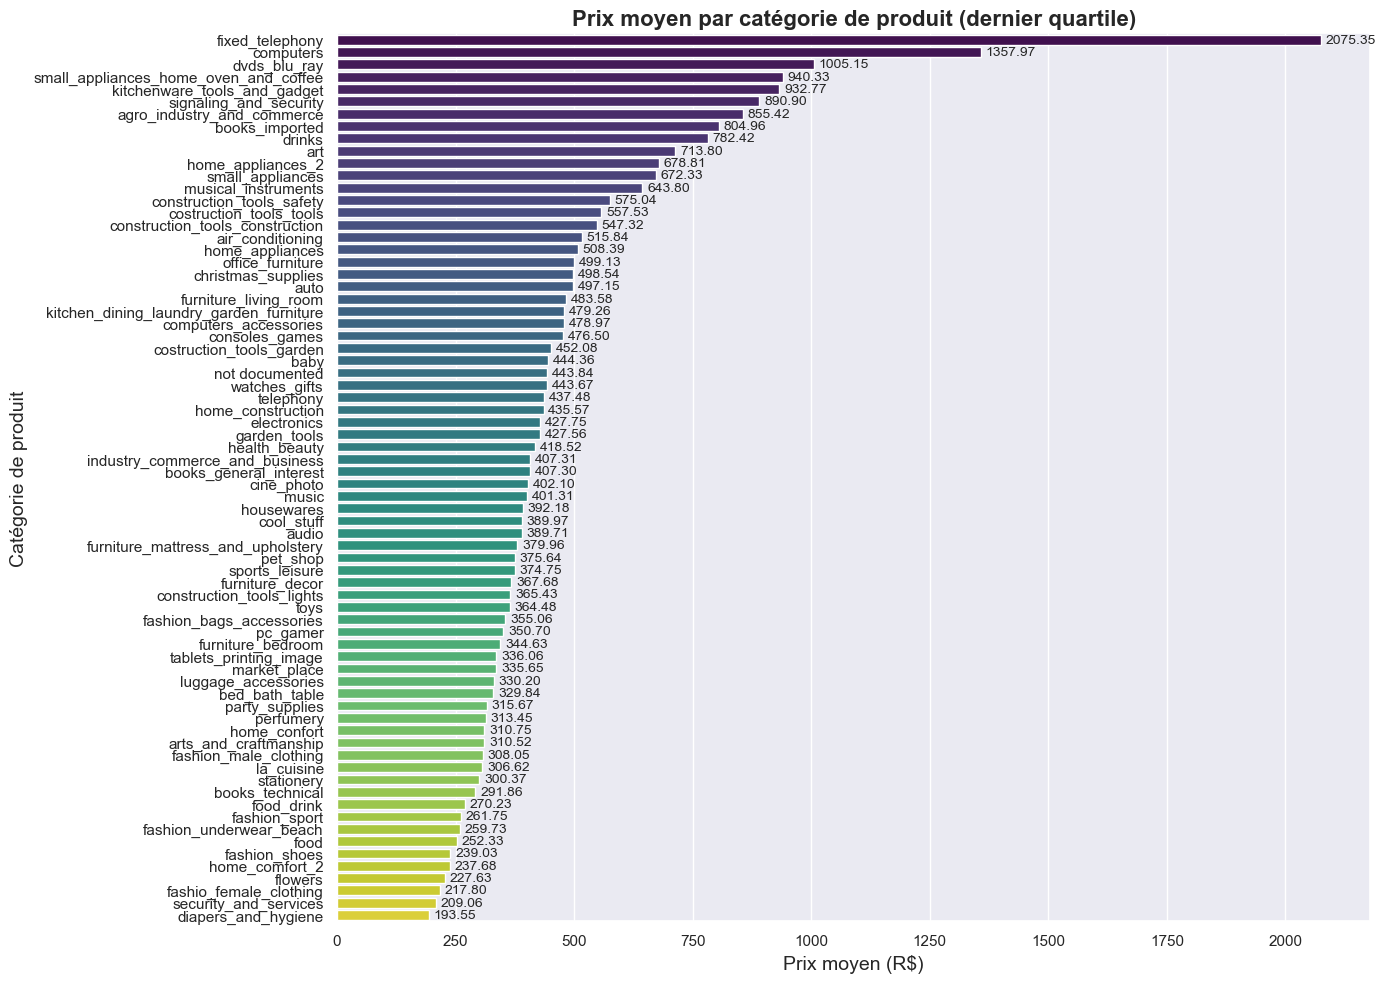

In [ ]:
ventes_payement['price'] = np.select(
    [
        ventes_payement['payment_method'] == 'Boleto',
        ventes_payement['payment_method'] == 'Carte de crédit',
        ventes_payement['payment_method'] == 'Carte de débit',
        ventes_payement['payment_method'] == 'Voucher',
        ventes_payement['payment_method'].isnull()
    ],
    [
        ventes_payement['value_boleto'],
        ventes_payement['value_credit_card'],
        ventes_payement['value_debit_card'],
        ventes_payement['value_voucher'],
        ventes_payement['value_not_defined']
    ],
    default=0  
)

price_threshold = ventes_payement['price'].quantile(0.75)
df_couteux = ventes_payement[ventes_payement['price'] >= price_threshold].copy()


prix_moyen_par_categorie = (
    df_couteux.groupby('category_name')['price']
    .mean()
    .reset_index()
    .sort_values(by='price', ascending=False)
)


plt.figure(figsize=(14, 10)) 
sns.barplot(data=prix_moyen_par_categorie, x='price', y='category_name', palette="viridis")
plt.xlabel("Prix moyen (R$)", fontsize=14)
plt.ylabel("Catégorie de produit", fontsize=14)
plt.title("Prix moyen par catégorie de produit (dernier quartile)", fontsize=16, weight='bold')


for i, price in enumerate(prix_moyen_par_categorie['price']):
    plt.text(price + 10, i, f"{price:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

#### 5 - Satisfactions sur l'offre haut de gamme des catégories problématique

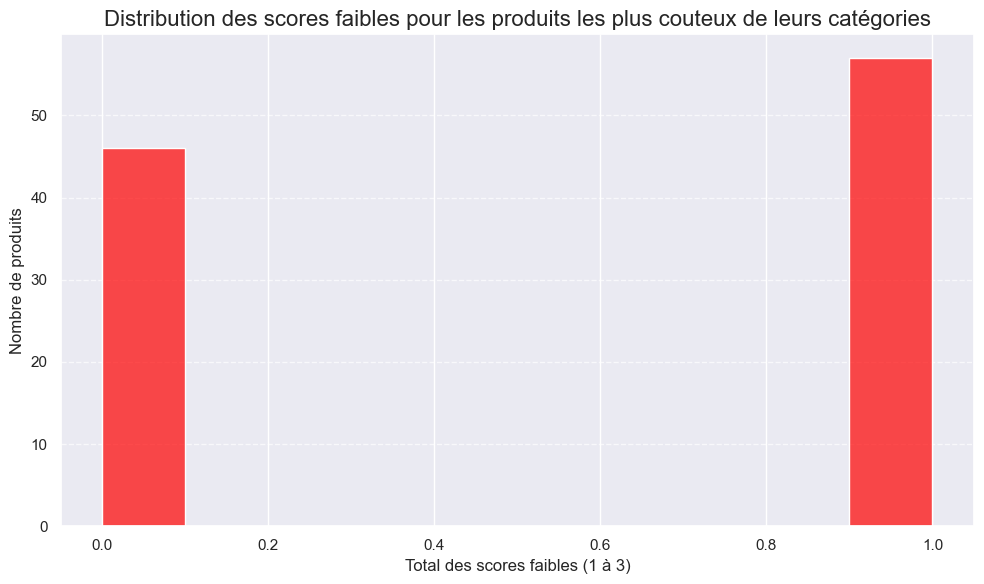

In [ ]:
categories_problematique = ['art', 'cds_dvds_musicals', 'christmas_supplies', 'la_cuisine', 
                            'fixed_telephony', 'drinks', 'dvds_blu_ray', 'flowers', 'cine_photo']

df_low_rate_top_categories = df_couteux[df_couteux['category_name'].isin(categories_problematique)]


median_price = df_low_rate_top_categories['price'].median()

df_above_median = df_low_rate_top_categories[df_low_rate_top_categories['price'] > median_price]

df_above_median['low_score_total'] = (
    df_above_median['score_1'] +
    df_above_median['score_2'] +
    df_above_median['score_3']
)

plt.figure(figsize=(10, 6))
sns.histplot(df_above_median['low_score_total'], bins=10, kde=False, color='red', alpha=0.7)
plt.xlabel("Total des scores faibles (1 à 3)")
plt.ylabel("Nombre de produits")
plt.title("Distribution des scores faibles pour les produits les plus couteux de leurs catégories", fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Ce graphique nous montre que pratiquement la moitié des produits présente un score faible de 1 à 3 contre sans note à 5. On peut donc en déduire que l'ensemble des produits de cette catégorie n'est pas problématique. 

#### 6 - Impacte des délais sur l'offre haut de gamme

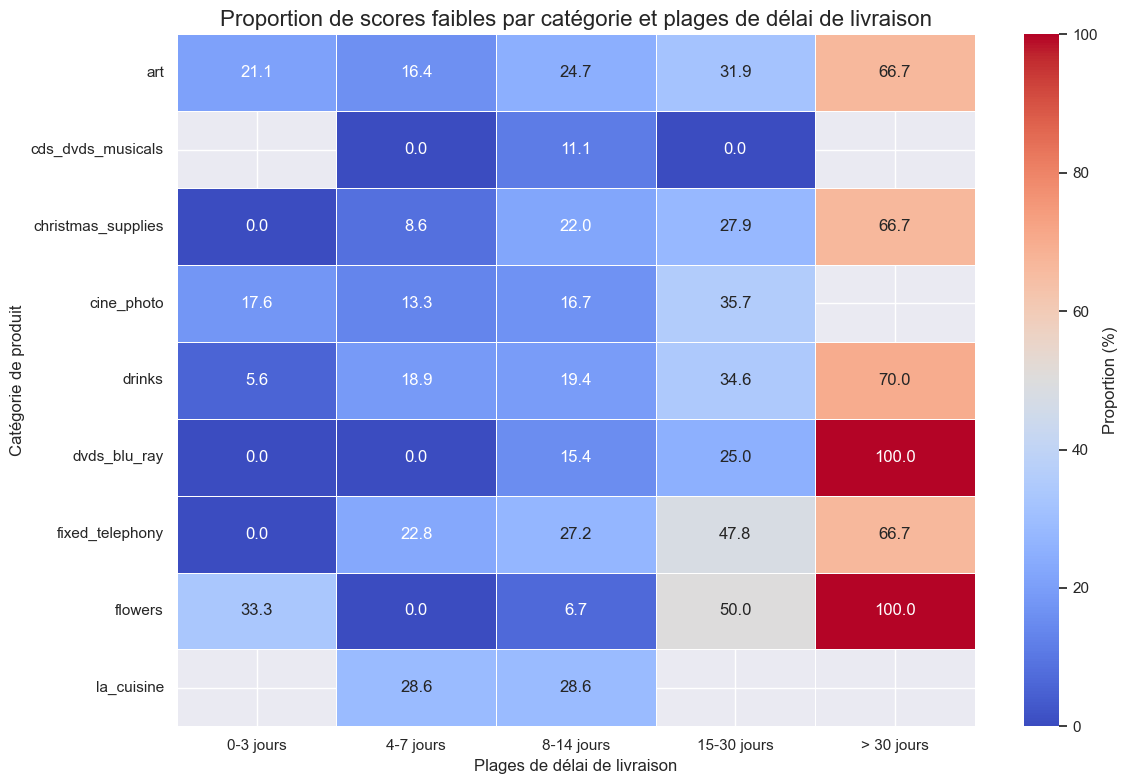

In [98]:


df_filtered = ventes_payement[ventes_payement['category_name'].isin(categories_problematique)]

# Calculer le délai de livraison
df_filtered['delivery_time'] = (df_filtered['delivered_customer'] - df_filtered['purchase_timestamp']).dt.days

# Regrouper les délais de livraison en plages
bins = [-1, 3, 7, 14, 30, df_filtered['delivery_time'].max()]
labels = ['0-3 jours', '4-7 jours', '8-14 jours', '15-30 jours', '> 30 jours']
df_filtered['delivery_time_range'] = pd.cut(df_filtered['delivery_time'], bins=bins, labels=labels)

# Ajouter une colonne pour indiquer les scores faibles
df_filtered['is_score_low'] = df_filtered[['score_1', 'score_2', 'score_3']].sum(axis=1) > 0

# Grouper les données par catégorie et plages de délai de livraison
heatmap_data = df_filtered.groupby(['category_name', 'delivery_time_range']).agg(
    total_low_scores=('is_score_low', 'sum'),
    total_reviews=('is_score_low', 'count')
).reset_index()

# Calculer la proportion des scores faibles
heatmap_data['low_score_percentage'] = (heatmap_data['total_low_scores'] / heatmap_data['total_reviews']) * 100

# Réorganiser les données en pivot pour créer une heatmap
heatmap_pivot = heatmap_data.pivot(index='category_name', columns='delivery_time_range', values='low_score_percentage')

# Créer la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Proportion (%)'})
plt.title("Proportion de scores faibles par catégorie et plages de délai de livraison", fontsize=16)
plt.xlabel("Plages de délai de livraison")
plt.ylabel("Catégorie de produit")
plt.tight_layout()
plt.show()



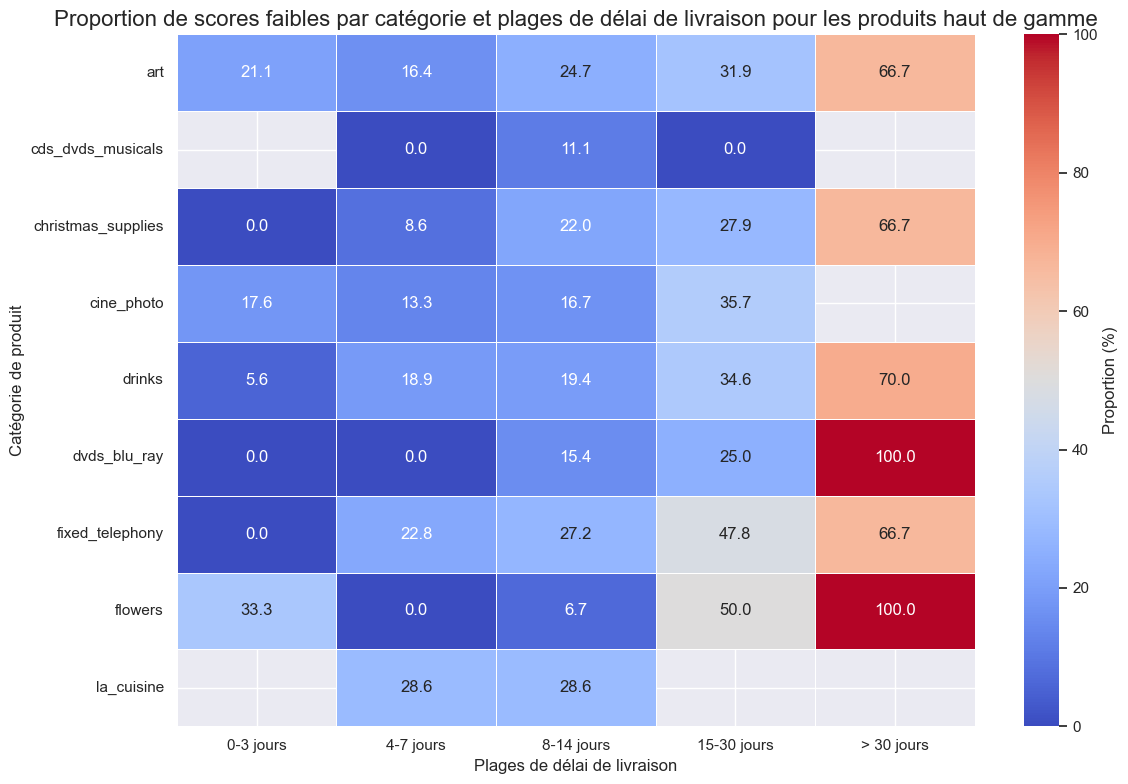

In [100]:
categories_problematique = ['art', 'cds_dvds_musicals', 'christmas_supplies', 'la_cuisine', 
                            'fixed_telephony', 'drinks', 'dvds_blu_ray', 'flowers', 'cine_photo']
df_filtered_couteux = df_couteux[df_couteux['category_name'].isin(categories_problematique)]

df_filtered_couteux['delivery_time'] = (df_filtered_couteux['delivered_customer'] - df_filtered_couteux['purchase_timestamp']).dt.days

bins = [-1, 3, 7, 14, 30, df_filtered_couteux['delivery_time'].max()]
labels = ['0-3 jours', '4-7 jours', '8-14 jours', '15-30 jours', '> 30 jours']
df_filtered_couteux['delivery_time_range'] = pd.cut(df_filtered_couteux['delivery_time'], bins=bins, labels=labels)

df_filtered_couteux['is_score_low'] = df_filtered_couteux[['score_1', 'score_2', 'score_3']].sum(axis=1) > 0

heatmap_data = df_filtered.groupby(['category_name', 'delivery_time_range']).agg(
    total_low_scores=('is_score_low', 'sum'),
    total_reviews=('is_score_low', 'count')
).reset_index()

heatmap_data['low_score_percentage'] = (heatmap_data['total_low_scores'] / heatmap_data['total_reviews']) * 100

heatmap_pivot = heatmap_data.pivot(index='category_name', columns='delivery_time_range', values='low_score_percentage')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Proportion (%)'})
plt.title("Proportion de scores faibles par catégorie et plages de délai de livraison pour les produits haut de gamme", fontsize=16)
plt.xlabel("Plages de délai de livraison")
plt.ylabel("Catégorie de produit")
plt.tight_layout()
plt.show()

Ces graphiques nous montre que le retard n'est pas du tout toléré pour les produits les plus cher. 

#### 7 - Impact des retards sur l'offre haut de gamme

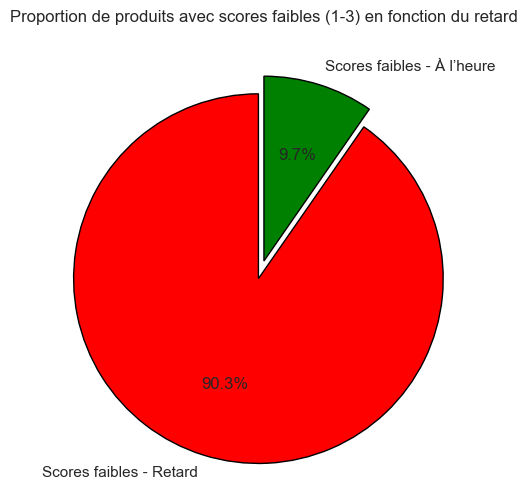

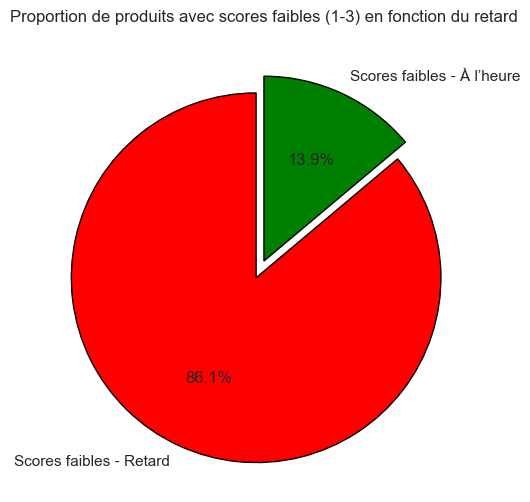

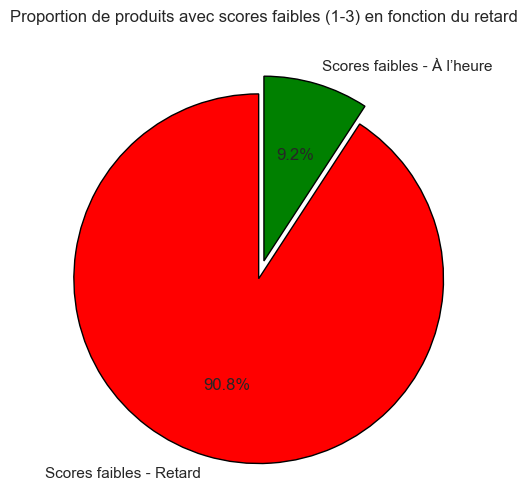

In [ ]:
def impacte_retard(dataframe): 

    df = dataframe.copy()
    df['delivery_time'] = (df['delivered_customer'] - df['purchase_timestamp']).dt.days

    df['is_late'] = df['delivery_time'] > 0  # True si la commande est en retard, False sinon

    df['is_score_low'] = df[['score_1', 'score_2', 'score_3']].sum(axis=1) > 0

    score_low_late = df[df['is_late']]['is_score_low'].sum()
    score_low_on_time = df[~df['is_late']]['is_score_low'].sum()

    labels = ['Scores faibles - Retard', 'Scores faibles - À l’heure']
    sizes = [score_low_late, score_low_on_time]
    colors = ['red', 'green']

    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, explode=(0.1, 0), wedgeprops={'edgecolor': 'black'})
    plt.title("Proportion de produits avec scores faibles (1-3) en fonction du retard")
    plt.show()

impacte_retard(ventes_payement)
impacte_retard(df_filtered)
impacte_retard(df_couteux)


Lorsque l'on regarde l'impacte des retards sur l'enssemble de nos donner, on observe environ 10% de retour négatif pour un produit arrivé à l'heure prévu. **Ce chiffre double lorsque l'on filtre pour ne garder que les catégories problématique.** Ainsi, nous pouvons en conclure qu'une certaines offre dans ces produits ne convient pas aux clients. 

Cependant, le dernier graphique qui filtre par catégories à problème et par produit haut de gamme nous montre que l'offre haut de gamme n'a pas une réelle importance dans le score négatif. 

En effet, les produits étant à la fois dans une catégorie problématique & étant haut de gamme sont peu nombreux, ce qui peut expliquer des moyen d'insatisfaction parfois très haute. 

#### 8 - Nombre de produits impacté 

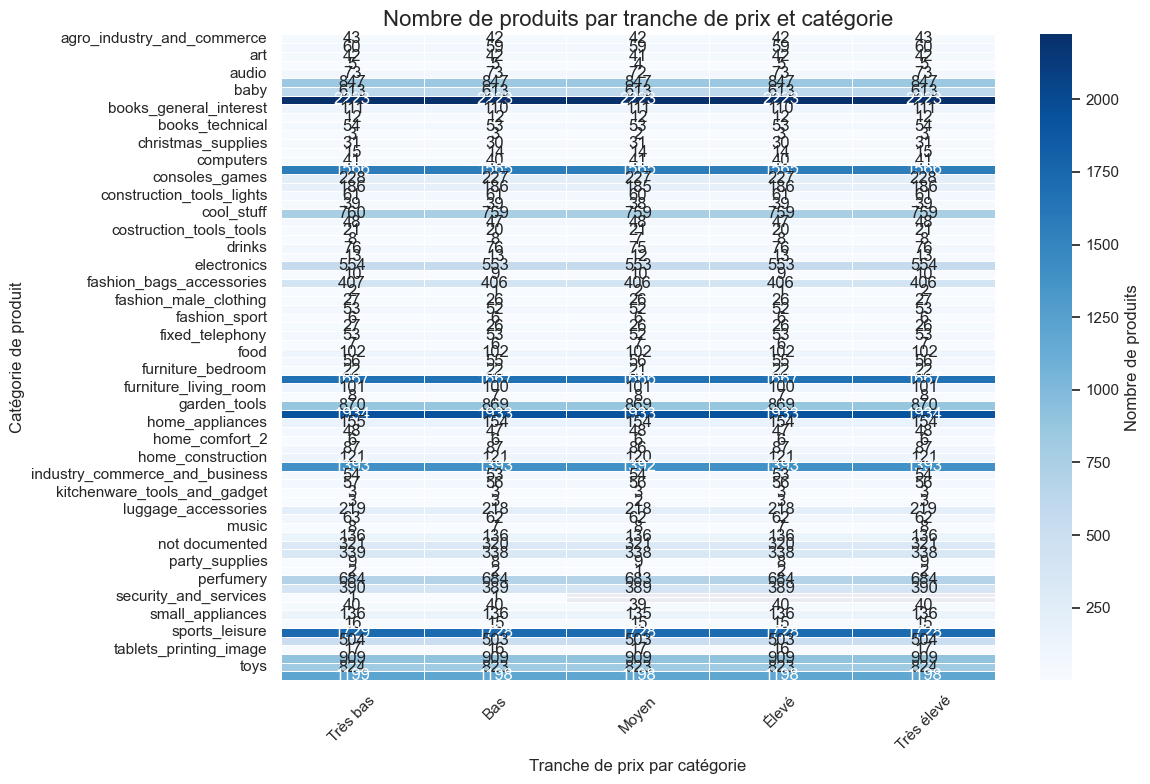

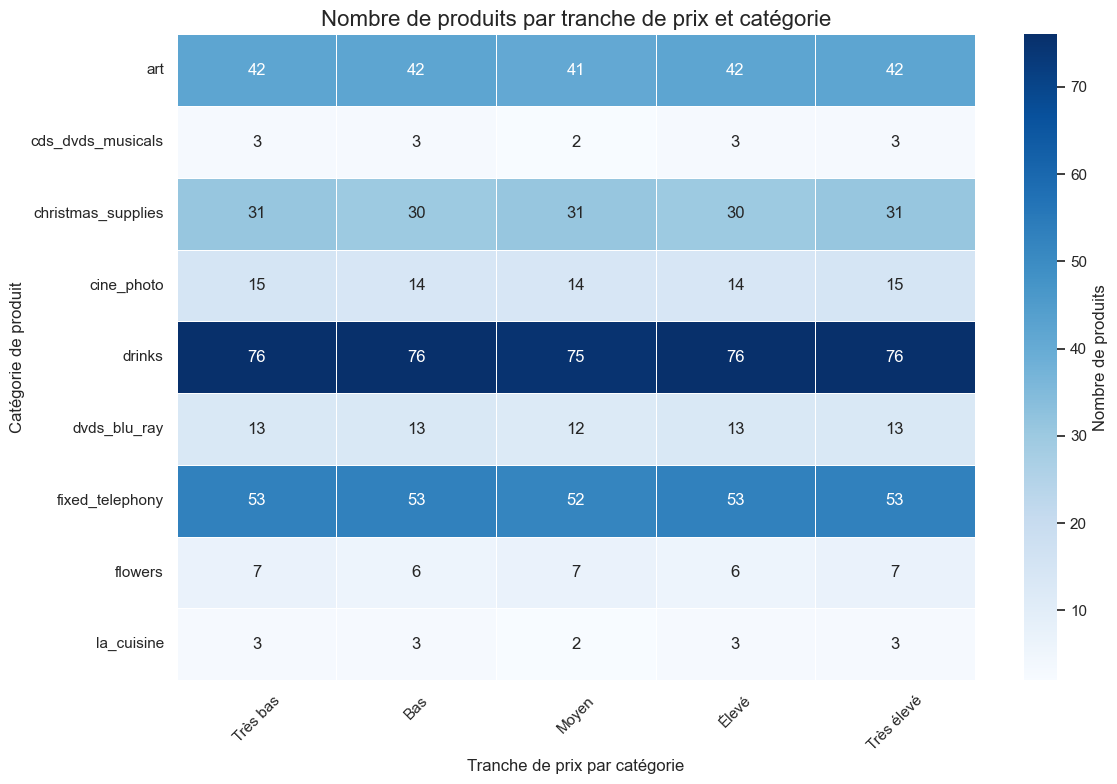

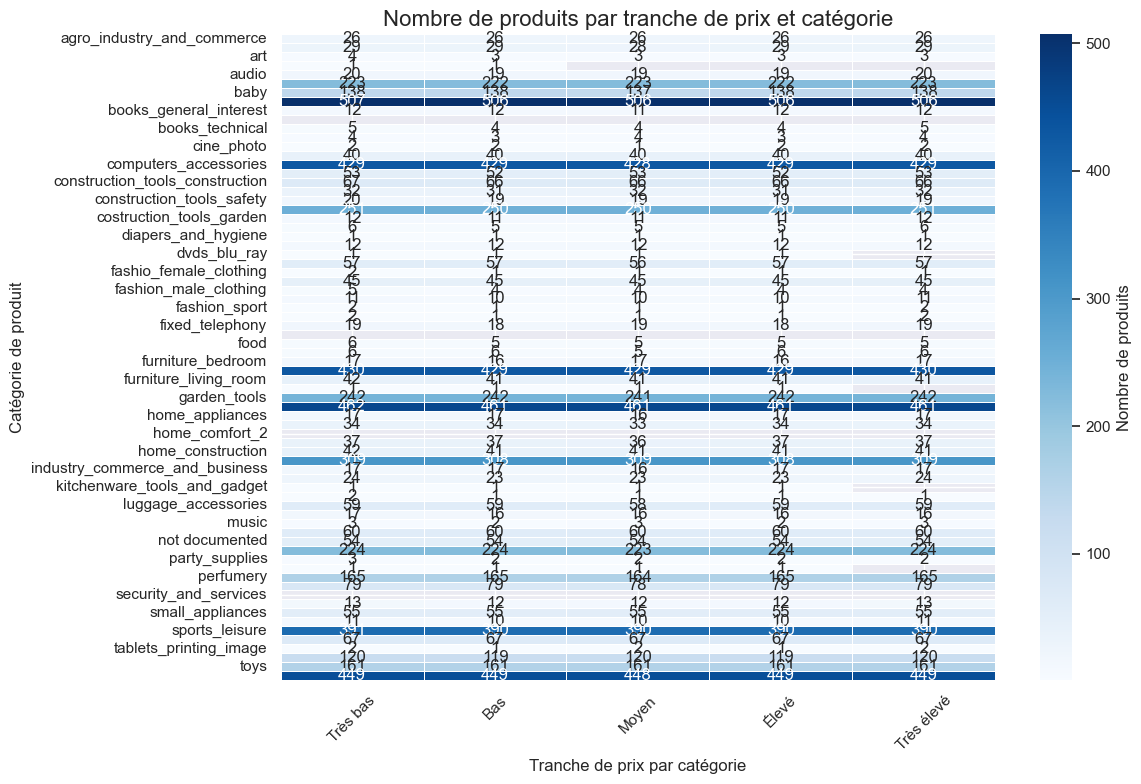

In [102]:
def vente_produit_par_prix_categorie(df):
    dataframe = df.copy()
    
    dataframe['price'] = dataframe[['value_boleto', 'value_credit_card', 'value_debit_card', 'value_voucher', 'value_not_defined']].max(axis=1)

    dataframe['price_rank'] = dataframe.groupby('category_name')['price'].rank(method='first')

    price_labels = ["Très bas", "Bas", "Moyen", "Élevé", "Très élevé"]

    def adaptive_qcut(x):
        num_bins = min(5, x.nunique())  
        if num_bins > 1:  
            return pd.qcut(x, q=num_bins, labels=price_labels[:num_bins], duplicates='drop')
        else:
            return pd.Series(["Inconnu"] * len(x), index=x.index)

    dataframe['price_category'] = dataframe.groupby('category_name')['price_rank'].transform(adaptive_qcut)

    heatmap_data = dataframe.groupby(['category_name', 'price_category']).size().reset_index(name='count')

    heatmap_pivot = heatmap_data.pivot(index='category_name', columns='price_category', values='count')

    heatmap_pivot = heatmap_pivot[price_labels]  

    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_pivot, cmap='Blues', annot=True, fmt=".0f", linewidths=0.5, cbar_kws={'label': 'Nombre de produits'})
    plt.title("Nombre de produits par tranche de prix et catégorie", fontsize=16)
    plt.xlabel("Tranche de prix par catégorie")
    plt.ylabel("Catégorie de produit")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

vente_produit_par_prix_categorie(ventes_payement)
vente_produit_par_prix_categorie(df_filtered)
vente_produit_par_prix_categorie(df_couteux)
